# 1. Import packages



The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
import sys
import os
sys.path.append(r"C:\Users\cosmosyw\Documents\Softwares")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd
import numpy as np

import pickle
import time

import matplotlib.pyplot as plt
import seaborn as sns

import tqdm

import copy

24176


In [2]:
import multiprocessing as mp

import time

In [3]:
import pickle

# 2. Load refgen df

Get an example of [refgen](../../resources/refgen_df_for_jie.csv)

In [4]:
codebook_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
df_refgen_savename = os.path.join(codebook_folder,'refgen_df_for_jie.csv')

In [5]:
df_refgen=pd.read_csv(df_refgen_savename,index_col=0)
df_refgen['chr'] = df_refgen['chr'].apply(lambda x: 'chr'+x)
df_refgen

name    id   chr  chr_order library  dtype  \
0         1:3742742-3759944     1  chr1          0   CTP11  combo   
1         1:6245958-6258969     2  chr1          1   CTP11  combo   
2         1:8740008-8759916     3  chr1          2   CTP11  combo   
3         1:9627926-9637875     1  chr1          3   CTP13  combo   
4         1:9799472-9811359     2  chr1          4   CTP13  combo   
...                     ...   ...   ...        ...     ...    ...   
1977  X:166247682-166259932  1059  chrX         60   CTP11  combo   
1978  X:167157164-167167452   990  chrX         61   CTP13  combo   
1979  X:168746045-168757590  1060  chrX         62   CTP11  combo   
1980  X:169963295-170005197   991  chrX         63   CTP13  combo   
1981      Y:1245775-1259992  1062  chrY          0   CTP11  combo   

                     loci_name      start        end  hyb      delta  \
0         chr1_3742742_3759944    3742742    3759944    0          0   
1         chr1_6245958_6258969    6245958    6258969    1    2503216   
2         chr1_8740008_8759916    8740008    8759916    2    4997266   
3         chr1_9627926_9637875    9627926    9637875    3    5885184   
4         chr1_9799472_9811359    9799472    9811359    4    6056730   
...                        ...        ...        ...  ...        ...   
1977  chrX_166247682_166259932  166247682  166259932   60  159996393   
1978  chrX_167157164_167167452  167157164  167167452   61  160905875   
1979  chrX_168746045_168757590  168746045  168757590   62  162494756   
1980  chrX_169963295_170005197  169963295  170005197   63  163712006   
1981      chrY_1245775_1259992    1245775    1259992    0          0   

      region_id  
0             1  
1             2  
2             3  
3             4  
4             5  
...         ...  
1977       1978  
1978       1979  
1979       1980  
1980       1981  
1981       1982  

[1982 rows x 12 columns]

# 3. Prepare uid to cellID info

In [6]:
#from ImageAnalysis3 import segmentation_tools.cell
#from 
ExpFovCell_2_uid = {}

#from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
segLabel_folders = [
    r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Segmentation',
    r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220402-P_brain_CTP11-13_from_0329_warp\Analysis_0709\Segmentation',
    r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220419-CTP11-13_from_0415storm65\Analysis_0813\Segmentation',
    r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation'
]
rna_exp_names = ['20220304', '20220329', '20220415', '20220418']
#exp_names = ['20220419']

for _exp, _seg_fd in zip(rna_exp_names, segLabel_folders):
    _seg_fls = [os.path.join(_seg_fd, _fl) for _fl in os.listdir(_seg_fd) if '_Segmentation.hdf5' in _fl]
    for _fl in _seg_fls:
        # load segmentation label matrix and uids
        with h5py.File(_fl, 'r') as _f:
            for _fov_id in _f.keys():
                _fov_group = _f[list(_f.keys())[0]]
                _uid_group = _fov_group['cell_2_uid']
                for _cell_id in _uid_group.keys():
                    ExpFovCell_2_uid[(_exp, _fov_id, _cell_id)] = _uid_group[_cell_id][:][0].decode()

len(ExpFovCell_2_uid)

98501

In [7]:
print(list(ExpFovCell_2_uid.keys())[10])
ExpFovCell_2_uid[list(ExpFovCell_2_uid.keys())[10]]

('20220304', '0', '108')


'43264541939528399103238720269391680850'

In [8]:
# function for adding uid as finalCellID in the spot_df
def ExpFovCell_2_uid_from_FovCell (Fov_id, Cell_id, ExpFovCell_2_uid, Exp_name='None'):
    if Exp_name=='None':
        Exp_name = list(ExpFovCell_2_uid.keys())[0][0]
    Cell_uid = ExpFovCell_2_uid[Exp_name,Fov_id, Cell_id]
    return Cell_uid

# 4. Additional function for processing chr with overalpping loci

In [9]:
# function to consolidate overlapping loci;
# all decoded overlapping loci will be picked together
# the backup hyb column will be used to restore the original hyb info later
# drop redudant for the de_regfen to have unique hyb for each ref row and keep the redun for df result restoratin 
def process_redun_hyb_df (df_to_process_chr, redun_hyb_pair, hyb_col = 'hyb', drop_redun = True):
    import copy
    df_new = copy.deepcopy(df_to_process_chr)
    df_new[f'{hyb_col}_copy'] = df_to_process_chr[hyb_col]
    if drop_redun: # if only keep one for all overlapping loci
        df_new = df_new[~df_new[hyb_col].isin(np.array(redun_hyb_pair)[redun_hyb_pair!=np.min(redun_hyb_pair)])]

    hyb_list = df_new[hyb_col].tolist()
    new_hyb_list = [ ]
    for _hyb in hyb_list:
        if _hyb <= np.min(redun_hyb_pair):
            new_hyb_list.append(_hyb)
        elif _hyb in redun_hyb_pair:
            new_hyb_list.append(np.min(redun_hyb_pair))
        else:
            new_hyb_list.append(_hyb-1)
            
    df_new[hyb_col]=new_hyb_list
    return df_new

In [10]:
df_refgen_chr = df_refgen[df_refgen['chr']=='chr1']
gdintervals = df_refgen_chr['start'].diff()
print(np.sum(gdintervals<1000))
print(np.where(gdintervals<1000))
ind_close = np.where(gdintervals<1000)[0][0]
df_refgen_chr.iloc[ind_close-1:ind_close+1]

1
(array([56], dtype=int64),)


name  id   chr  chr_order library  dtype  \
55  1:68746515-68772592  30  chr1         56   CTP13  combo   
56  1:68746941-68759836  27  chr1         55   CTP11  combo   

                 loci_name     start       end  hyb     delta  region_id  
55  chr1_68746515_68772592  68746515  68772592   55  65003773         56  
56  chr1_68746941_68759836  68746941  68759836   56  65004199         57

In [11]:
df_refgen_chr = df_refgen[df_refgen['chr']=='chr3']
gdintervals = df_refgen_chr['start'].diff()
print(np.sum(gdintervals<1000))
print(np.where(gdintervals<1000))
ind_close = np.where(gdintervals<1000)[0][0]
df_refgen_chr.iloc[ind_close-1:ind_close+1]

1
(array([71], dtype=int64),)


name    id   chr  chr_order   library   dtype  \
1209  3:95516786-95536786  Ctss  chr3         71  CTP12tss  unique   
1210  3:95517538-95535402   186  chr3         70     CTP13   combo   

                   loci_name     start       end  hyb     delta  region_id  
1209  chr3_95516786_95536786  95516786  95536786   70  91770439       1210  
1210  chr3_95517538_95535402  95517538  95535402   71  91771191       1211

In [12]:
# record the overlapping hyb number for processing later
redun_hyb_dict = {'chr1':[55,56],'chr3':[70,71]}
redun_hyb_dict 

{'chr1': [55, 56], 'chr3': [70, 71]}

# 5. Processing each replicate

Decoded data for replicate can be generated from notebook for example:

[1_prepare_spot_dataset_jie_exp0713](./1_prepare_spot_dataset_jie_exp0713.ipynb)

In [13]:
merged_spot_main_folder = r'\\10.245.74.158\Chromatin_NAS_8\Exported_data\jie_CW_decode'
dna_exp_key_list = ['20220316','20220402','20220419','20220713']

param_fname = r'CW_v2'
output_subfolder = param_fname

# 2. Import functions

The modified jie is the same version as described below except that the packages are named differently from the ones in the repository:

The link to get [jie_CW](https://github.com/cosmosyw/jie/tree/0f797efcc52c1e9822a3cd03d8980cba9315b468) 

The link to get [jie_CW.aligner_CW_v2](https://github.com/cosmosyw/jie/blob/0f797efcc52c1e9822a3cd03d8980cba9315b468/jie/aligner.py)

In [14]:
import jie
#from jie_CW.jie import aligner, aligner_SL, aligner_CW
from jie.jie import aligner_CW_v2
# aligner_CW CW's version
# CW's aligner's original version (?) that take the cdfs
# github's current version

from jie.jie import plot

## 5.1 Experiment 20220316

### (a) Load spot df from individual replicate

In [15]:
# exp folder
exp_key_order = 0 
dna_exp_key = dna_exp_key_list[exp_key_order]
dna_exp_key

'20220316'

In [16]:
# concat all converted spot dataframes

merged_spot_folder=os.path.join(merged_spot_main_folder,f'{dna_exp_key}exp')

df_list = []
#for _ct in tqdm([0,1,2,3,4,5]):
for _ct in tqdm.tqdm(list(range(0,30))):
    coord_df_exp_subfname = os.path.join(merged_spot_folder, f'{dna_exp_key}exp_cand_spots_part{_ct}.csv')
    if os.path.exists(coord_df_exp_subfname):
        df_list.append(pd.read_csv(coord_df_exp_subfname))
    #print(_ids)
spot_dfs = pd.concat(df_list)
##############################################################
# add uid as finalCellID for picking by cell

spot_FovCell_list = []
#for Fov_id, Cell_id in tqdm(zip(df_4dn['FOV'],df_4dn['orig_cellID'])):
for Fov_id, Cell_id in tqdm.tqdm(zip(spot_dfs['FOV'],spot_dfs['orig_cellID'])):
    spot_FovCell_list.append(ExpFovCell_2_uid_from_FovCell (str(Fov_id), 
                                                            Cell_id.split('Cell-')[1], 
                                                            ExpFovCell_2_uid, Exp_name=rna_exp_names[exp_key_order]))
#df_4dn['Cell_ID'] = df_4dn.apply(lambda x: ExpFovCell_2_uid_from_FovCell(x['FOV'],x['orig_cellID'],ExpFovCell_2_uid),axis=1)
spot_dfs['finalcellID']=spot_FovCell_list

# add chr to num if not done so yet
if 'chr' not in spot_dfs['chr'].tolist()[0]:
    spot_dfs['chr'] = spot_dfs['chr'].apply(lambda x: 'chr'+x)

##################################################################
# clean up spot df
spot_dfs.reset_index(inplace=True)
spot_dfs['rowID'] = spot_dfs.index
spot_dfs=spot_dfs.drop(columns='level_0')
spot_dfs.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:11<00:00,  4.40s/it]
49906588it [00:39, 1250591.65it/s]


region_name    chr     start       end      z_hat       x_hat  \
0  17:73751388-73759983  chr17  73751388  73759983  60.678742  252.251467   
1     4:8751988-8760000   chr4   8751988   8760000  45.530849  254.007367   
2   4:46250010-46259963   chr4  46250010  46259963  38.266079  265.314327   
3  10:76252105-76259992  chr10  76252105  76259992  38.419541  240.145913   
4   1:91252155-91259954   chr1  91252155  91259954  51.856107  236.569457   

         y_hat  center_intensity  center_internal_dist codebook_name  ...  \
0  1480.571467       6636.495367            111.695218         CTP11  ...   
1  1470.698267      11722.954500             46.061746         CTP11  ...   
2  1491.207800       5803.133467             71.473181         CTP11  ...   
3  1491.109633       6059.730000             20.031844         CTP11  ...   
4  1455.344300       6261.333600             45.158738         CTP11  ...   

  orig_cellID  FOV  replicate  sig_x sig_y  sig_z  hyb  celltype  \
0     Cell-12    0   20220316      1     1      1   52     Oligo   
1     Cell-12    0   20220316      1     1      1    6     Oligo   
2     Cell-12    0   20220316      1     1      1   37     Oligo   
3     Cell-12    0   20220316      1     1      1   63     Oligo   
4     Cell-12    0   20220316      1     1      1   77     Oligo   

                               finalcellID  rowID  
0  259202492748634617304623818845147108919      0  
1  259202492748634617304623818845147108919      1  
2  259202492748634617304623818845147108919      2  
3  259202492748634617304623818845147108919      3  
4  259202492748634617304623818845147108919      4  

[5 rows x 24 columns]

### (b) Pick spots using jie_CW

In [17]:
# save results into chr_pts format
chr_pts = {'replicate': {},
           'FOV': {},
           'orig_cellID': {},
           'finalcellID': {},
           'celltype': {},
           'chr': {},
           'data': {}}



# group by celltype, chr, finalcellD
for i, (name, group) in tqdm.tqdm(enumerate(spot_dfs.groupby(by=['celltype', 'chr', 'finalcellID']))):
            
    # make copy
    _df_cell = copy.deepcopy(group)
    
    # drop columns
    _df_cell = _df_cell[['replicate', 'FOV', 'orig_cellID', 'finalcellID',  
                         'celltype','chr', 'hyb', 'region_name', 
                         'x_hat', 'y_hat', 'z_hat', 
                         'sig_x', 'sig_y', 'sig_z','rowID']]

    # sort by hyb_rnd
    _df_cell = _df_cell.sort_values(by=['hyb'])

    # reset index
    _df_cell.reset_index(inplace=True, drop = True)

    # save df
    chr_pts['replicate'][i] = _df_cell.iloc[0]['replicate']
    chr_pts['FOV'][i] = _df_cell.iloc[0]['FOV']
    chr_pts['orig_cellID'][i] = _df_cell.iloc[0]['orig_cellID']
    chr_pts['finalcellID'][i] = _df_cell.iloc[0]['finalcellID']
    chr_pts['celltype'][i] = _df_cell.iloc[0]['celltype']
    chr_pts['chr'][i] = _df_cell.iloc[0]['chr']
    chr_pts['data'][i] = _df_cell

    
del spot_dfs
chr_pts = pd.DataFrame(chr_pts)
chr_pts.head()

292857it [04:50, 1008.23it/s]


replicate  FOV orig_cellID                              finalcellID  \
0   20220316  110    Cell-159  100248997715285942293181957009945158269   
1   20220316  147     Cell-72  100320128349107686827736620229659368329   
2   20220316   12     Cell-15  100471792397581761099150459290276466001   
3   20220316   81     Cell-43  100645494773040598441840741335181821324   
4   20220316  102      Cell-5  100828630913519610520046533458214758500   

  celltype   chr                                               data  
0    Astro  chr1      replicate  FOV orig_cellID                ...  
1    Astro  chr1       replicate  FOV orig_cellID               ...  
2    Astro  chr1       replicate  FOV orig_cellID               ...  
3    Astro  chr1       replicate  FOV orig_cellID               ...  
4    Astro  chr1      replicate  FOV orig_cellID                ...

In [18]:
num_skip = 7
nm_per_bp = 0.3
isf = 0.2
tsf = 0.6
l_p_bp = 150

sel_chrom_keys = [chrom for chrom in np.unique(df_refgen.chr.values) if ('Y' not in chrom)]

Start processing chromosome chr1.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr1
00:23:19.41
42.4% cells have one or two copie(s); and 0.5% have more than three copies
Finish saving chromosome chr1.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr10.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr10
00:18:43.13
47.5% cells have one or two copie(s); and 0.8% have more than three copies
Finish saving chromosome chr10.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr11.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr11
00:15:57.22
42.9% cells have one or two copie(s); and 0.3% have more than three copies
Finish saving chromosome chr11.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

C:\Users\cosmosyw\AppData\Local\Temp\ipykernel_24176\2090130925.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (6, 4))


Finish saving chromosome chr19.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr2.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr2
00:25:30.17
40.9% cells have one or two copie(s); and 0.4% have more than three copies
Finish saving chromosome chr2.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr3.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr3
00:17:16.46
45.9% cells have one or two copie(s); and 0.6% have more than three copies
Finish saving chromosome chr3.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr4.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr4
00:18:27.71
45.6% cells have one or two copie(s); and 0.6% have more than three c

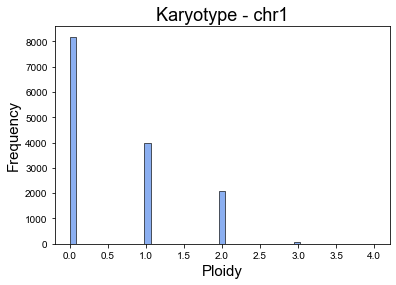

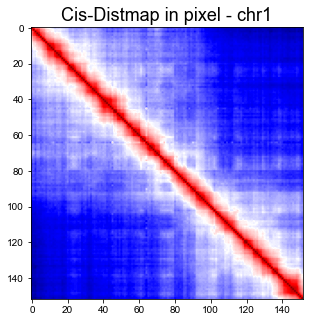

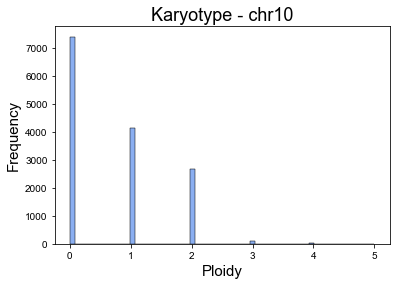

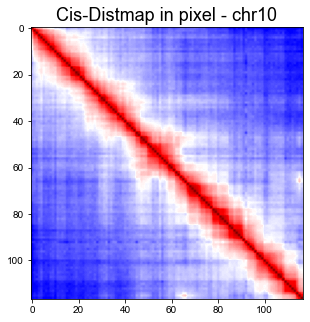

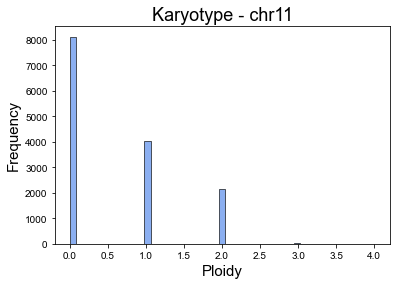

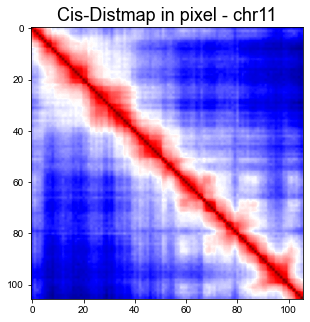

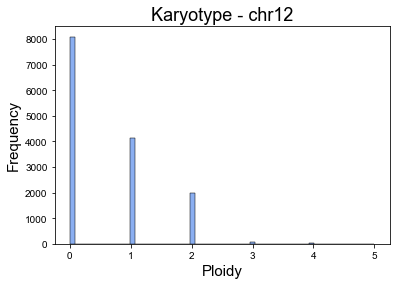

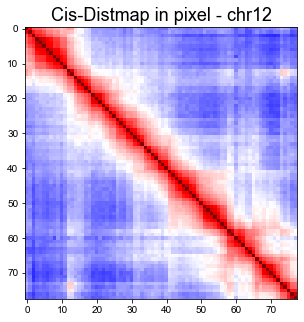

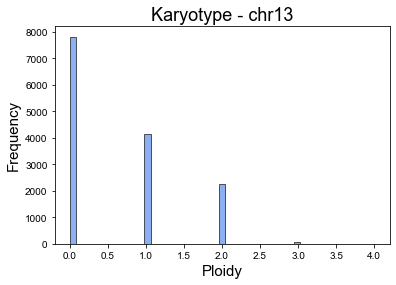

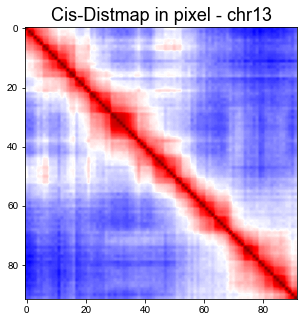

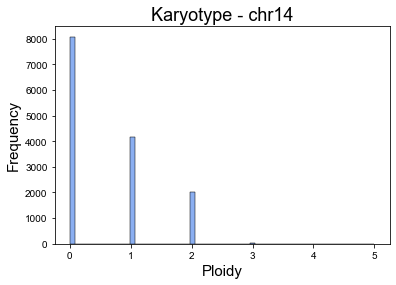

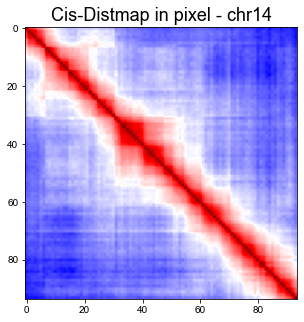

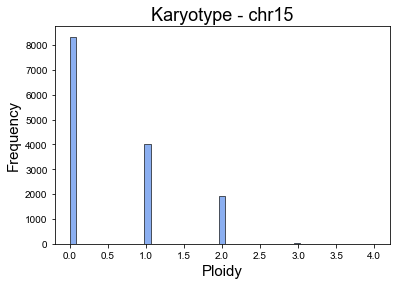

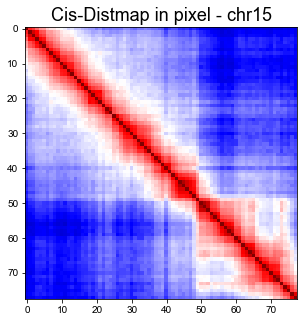

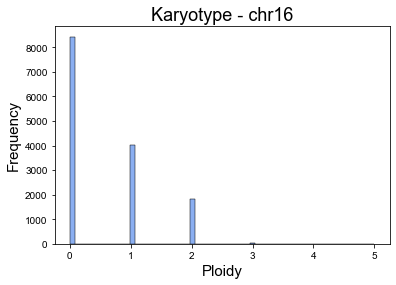

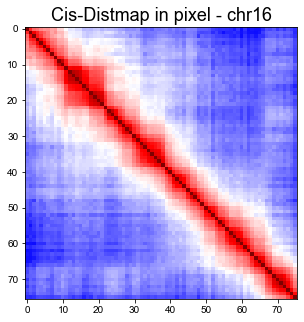

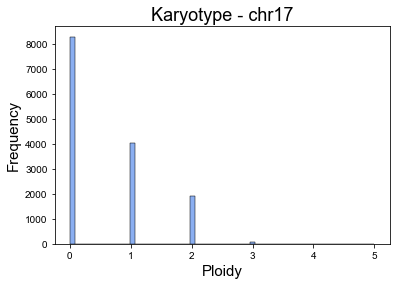

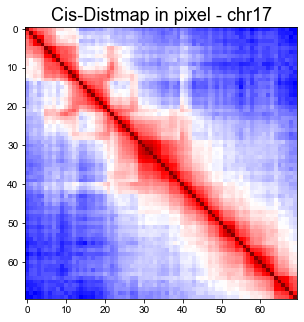

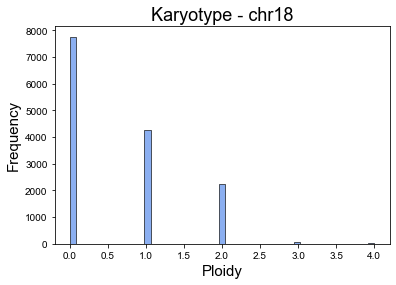

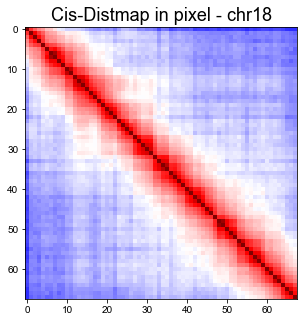

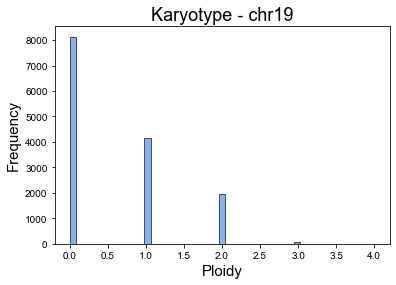

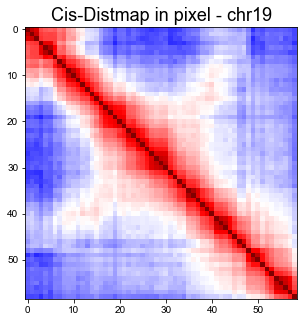

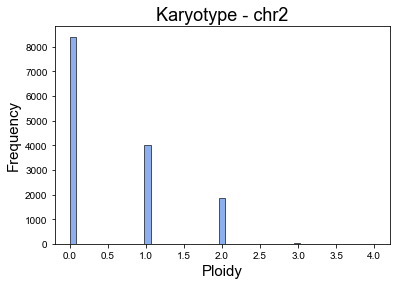

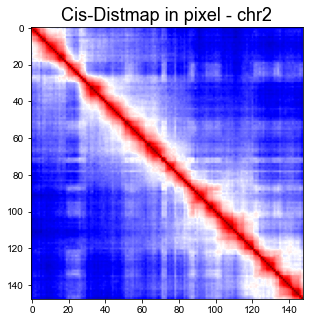

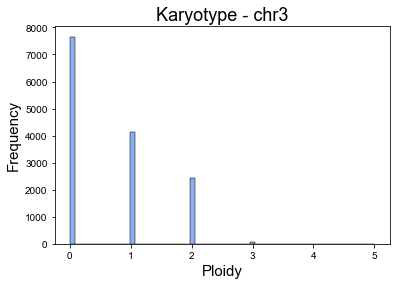

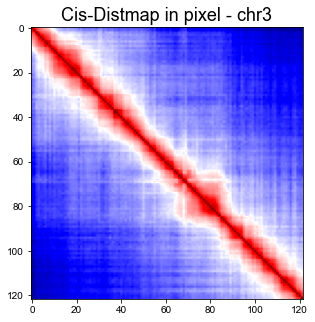

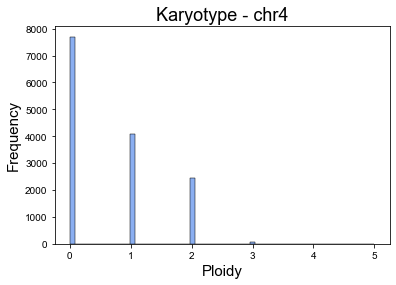

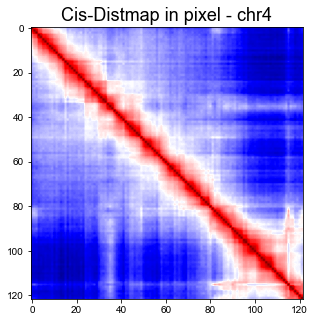

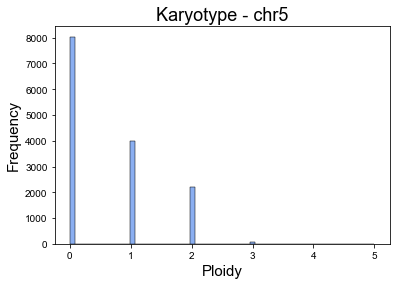

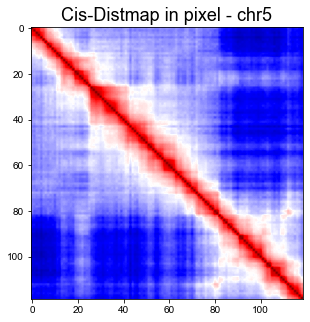

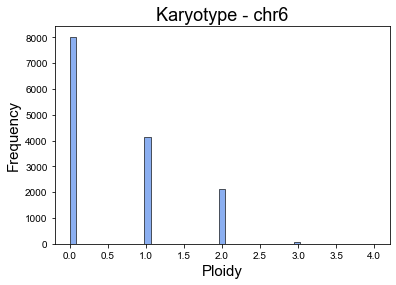

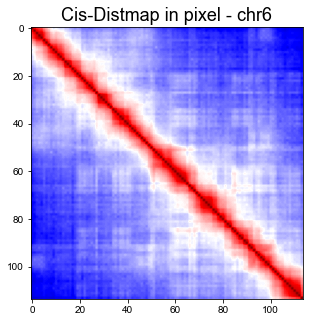

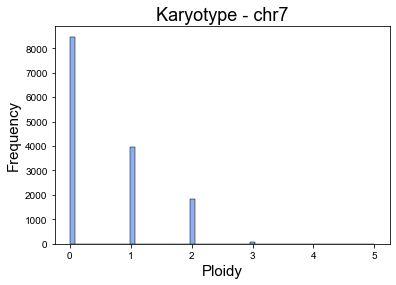

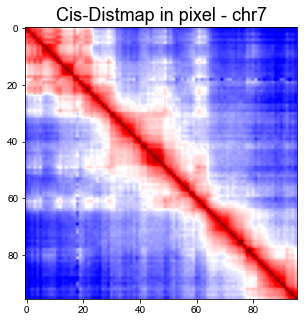

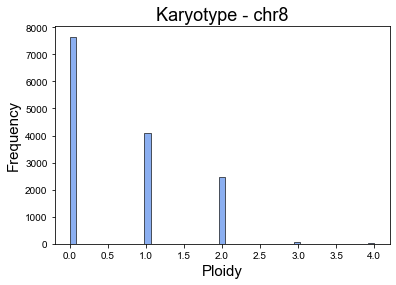

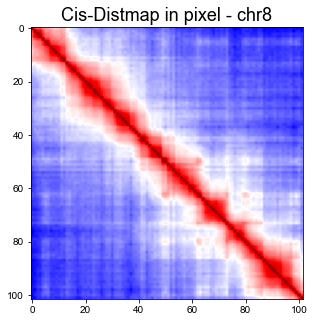

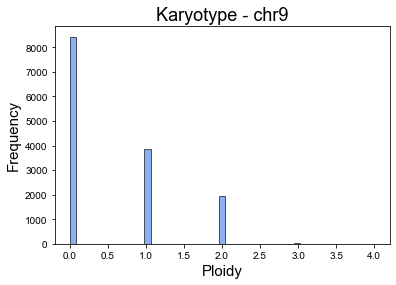

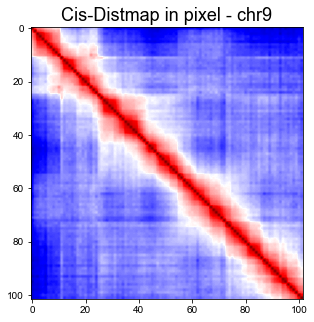

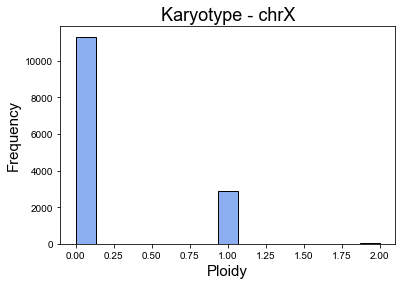

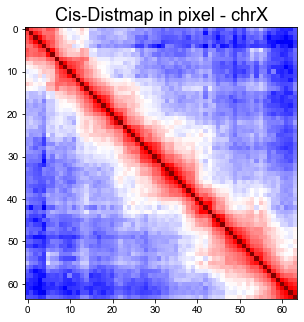

In [19]:
# pick spot with given params and plot result
%matplotlib inline

_save_pick = True

sel_celltypes = np.unique(chr_pts['celltype'])

if __name__ == '__main__':
    
    #for chosen_chrom in params.keys():
    for chosen_chrom in sel_chrom_keys:
        
        print(f'Start processing chromosome {chosen_chrom}.')
        
        print(f'Loading shared parameters as: num_skip:{num_skip}, isf:{isf},tsf:{tsf},nm_per_bp:{nm_per_bp}.')
        ####################################################
        # pick spots for each chr-fiber with mp of each cell
        # grab candidate coordinates
        sel_chr_pts = chr_pts[(chr_pts['celltype'].isin(sel_celltypes)) &
                              (chr_pts['chr'] == chosen_chrom)]['data'].tolist()
        
        # additional clean up for chr1 and chr3 
        if chosen_chrom in ['chr1','chr3']:
            redun_hyb_pair = redun_hyb_dict[chosen_chrom]
            sel_chr_pts_clean=[]
            for _chr_pt in sel_chr_pts:
                sel_chr_pts_clean.append(process_redun_hyb_df (_chr_pt, redun_hyb_pair, hyb_col = 'hyb', drop_redun = False))
            sel_chr_pts=sel_chr_pts_clean

        # grab reference genome (and clean up ref_df if chr1 or chr3)
        df_refgen_chr = df_refgen[df_refgen['chr'] == chosen_chrom]
        if chosen_chrom in ['chr1','chr3']:
            df_refgen_chr = process_redun_hyb_df (df_refgen_chr, redun_hyb_pair, hyb_col = 'hyb', drop_redun = True)
            
        gene_dist = df_refgen_chr['delta']
        # estimate bin size
        loci_starts = df_refgen_chr['start']
        intervals = [j-i for i, j in zip(loci_starts[:-1], loci_starts[1:])]
        bin_size = np.median(intervals)
        
        # set params
        nm_per_bps = [nm_per_bp,] * len(sel_chr_pts)
        #cdfs_threshs = [cdfs_thresh, ] * len(sel_chr_pts)
        num_skips = [num_skip,] * len(sel_chr_pts) 
        bin_sizes = [bin_size,] * len(sel_chr_pts)
        total_num_skip_fracs = [tsf,] * len(sel_chr_pts)
        init_num_skip_fracs = [isf,] * len(sel_chr_pts)
        gene_dists = [gene_dist.values,] * len(sel_chr_pts)
        l_p_bps = [l_p_bp, ] * len(sel_chr_pts)

        start_time = time.time()
            
        with mp.Pool(16) as pick_pool:
            pick_res = pick_pool.starmap(aligner_CW_v2.find_all_chr, zip(sel_chr_pts, gene_dists, bin_sizes,
                                                                      nm_per_bps, num_skips, 
                                                                      total_num_skip_fracs,
                                                                      init_num_skip_fracs, l_p_bps), chunksize=1)
            pick_pool.close()
            pick_pool.join()
            pick_pool.terminate()
        
        elapsed_time = time.time() - start_time
        
        print(f'Finish processing chromosome {chosen_chrom}')
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
        ###################################################
        # report chrom ploidy number, which could used to adjust the nm_per_bp

        karyo_new = [len(elem) for elem in pick_res]
        karyo_new_arr = np.array(karyo_new)
        frac_dip = (np.sum(karyo_new_arr==2)+np.sum(karyo_new_arr==1))/len(karyo_new_arr)
        frac_tri = (np.sum(karyo_new_arr>2)/len(karyo_new_arr))
        print(f'{round(frac_dip*100,1)}% cells have one or two copie(s); and {round(frac_tri*100,1)}% have more than three copies')
        ##############################################
        if not os.path.exists(os.path.join(merged_spot_folder, output_subfolder)):
            os.mkdir(os.path.join(merged_spot_folder, output_subfolder))
        # quick view of the pick info
        # plot ploidy number
        figure_folder = os.path.join(merged_spot_folder,output_subfolder,'figures')
        if not os.path.exists(figure_folder):
            os.mkdir(figure_folder)
        
        fig, axs = plt.subplots(figsize = (6, 4))
        sns.histplot(karyo_new, color='cornflowerblue');
        axs.set_ylabel('Frequency', fontsize = 15)
        axs.set_xlabel('Ploidy', fontsize = 15)
        axs.set_title('Karyotype - {0}'.format(chosen_chrom), fontsize = 18)
        fig.savefig(os.path.join(figure_folder, f"{dna_exp_key}exp_pick_{chosen_chrom}_chr_ploidy.png"))


        # plot distmap
        res_flat = [fiber for cell_res in pick_res for fiber in cell_res]
        med_dist_mat = plot.calc_med_dist_mat(res_flat, len(gene_dist))
        fig, axs = plt.subplots(figsize = (5, 5))
        axs.imshow(med_dist_mat*100, cmap = 'seismic_r', vmin=0, vmax = 3000)
        axs.set_title('Cis-Distmap in pixel - {0}'.format(chosen_chrom), fontsize = 18)
        fig.savefig(os.path.join(figure_folder, f"{dna_exp_key}exp_pick_{chosen_chrom}_distmap.png"))


        ###################################################
        # save individual df and concat
        if _save_pick:
            _res_flat_list = []
            # each cell
            for  _res in pick_res:
                # each fiber haploid
                if len(_res)>0:
                    for _fiber_ind, _fiber in enumerate(_res):
                        _fiber['fiberidx']=_fiber_ind+1
                        _res_flat_list.append(_fiber)
            merged_pick_res =  pd.concat(_res_flat_list)
            # clean up for chr1 or chr3
            if chosen_chrom in ['chr1','chr3']:
                merged_pick_res['hyb']=merged_pick_res['hyb_copy']
                merged_pick_res=merged_pick_res.drop(columns=['hyb_copy'])
                
            outputfile_name = f'{dna_exp_key}exp_pick_{chosen_chrom}'+'.h5'
            outputfile = os.path.join(merged_spot_folder, output_subfolder, outputfile_name)
            merged_pick_res.to_hdf(outputfile, key='df', mode='w')
            del(_res_flat_list)
            del(merged_pick_res)
            print(f'Finish saving chromosome {chosen_chrom}.')
            print(f'+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

In [20]:
del(chr_pts)

## 5.2 Experiment 20220402

### (a) Load spot df from individual replicate

In [21]:
# exp folder
exp_key_order = 1 
dna_exp_key = dna_exp_key_list[exp_key_order]
dna_exp_key

'20220402'

In [22]:
# concat all converted spot dataframes

merged_spot_folder=os.path.join(merged_spot_main_folder,f'{dna_exp_key}exp')

df_list = []
#for _ct in tqdm([0,1,2,3,4,5]):
for _ct in tqdm.tqdm(list(range(0,30))):
    coord_df_exp_subfname = os.path.join(merged_spot_folder, f'{dna_exp_key}exp_cand_spots_part{_ct}.csv')
    if os.path.exists(coord_df_exp_subfname):
        df_list.append(pd.read_csv(coord_df_exp_subfname))
    #print(_ids)
spot_dfs = pd.concat(df_list)
##############################################################
# add uid as finalCellID for picking by cell

spot_FovCell_list = []
#for Fov_id, Cell_id in tqdm(zip(df_4dn['FOV'],df_4dn['orig_cellID'])):
for Fov_id, Cell_id in tqdm.tqdm(zip(spot_dfs['FOV'],spot_dfs['orig_cellID'])):
    spot_FovCell_list.append(ExpFovCell_2_uid_from_FovCell (str(Fov_id), 
                                                            Cell_id.split('Cell-')[1], 
                                                            ExpFovCell_2_uid, Exp_name=rna_exp_names[exp_key_order]))
#df_4dn['Cell_ID'] = df_4dn.apply(lambda x: ExpFovCell_2_uid_from_FovCell(x['FOV'],x['orig_cellID'],ExpFovCell_2_uid),axis=1)
spot_dfs['finalcellID']=spot_FovCell_list

# add chr to num if not done so yet
if 'chr' not in spot_dfs['chr'].tolist()[0]:
    spot_dfs['chr'] = spot_dfs['chr'].apply(lambda x: 'chr'+x)

##################################################################
# clean up spot df
spot_dfs.reset_index(inplace=True)
spot_dfs['rowID'] = spot_dfs.index
spot_dfs=spot_dfs.drop(columns='level_0')
spot_dfs.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:07<00:00,  4.25s/it]
44698172it [00:35, 1252433.05it/s]


region_name    chr      start        end      z_hat       x_hat  \
0    9:43752798-43759971   chr9   43752798   43759971  54.022559  560.494100   
1     19:6253105-6259999  chr19    6253105    6259999  52.005891  579.649300   
2     15:6248179-6259974  chr15    6248179    6259974  29.710218  556.758547   
3  X:131245946-131259984   chrX  131245946  131259984  47.539787  580.878863   
4    8:28751526-28759983   chr8   28751526   28759983  18.480292  553.365803   

         y_hat  center_intensity  center_internal_dist codebook_name  ...  \
0  1301.650900      12723.666333             72.146059         CTP11  ...   
1  1316.427400       9984.205333             97.102592         CTP11  ...   
2  1289.234300       7435.318767            100.437839         CTP11  ...   
3  1335.327933       8607.377333             86.149562         CTP11  ...   
4  1317.896400      12170.558833            115.798191         CTP11  ...   

  orig_cellID  FOV  replicate  sig_x sig_y  sig_z  hyb  celltype  \
0     Cell-30    0   20220402      1     1      1   26       OPC   
1     Cell-30    0   20220402      1     1      1    4       OPC   
2     Cell-30    0   20220402      1     1      1    1       OPC   
3     Cell-30    0   20220402      1     1      1   45       OPC   
4     Cell-30    0   20220402      1     1      1   17       OPC   

                              finalcellID  rowID  
0  41638828408895128934160128056350820935      0  
1  41638828408895128934160128056350820935      1  
2  41638828408895128934160128056350820935      2  
3  41638828408895128934160128056350820935      3  
4  41638828408895128934160128056350820935      4  

[5 rows x 24 columns]

### (b) Pick spots using jie_CW

In [23]:
# save results into chr_pts format
chr_pts = {'replicate': {},
           'FOV': {},
           'orig_cellID': {},
           'finalcellID': {},
           'celltype': {},
           'chr': {},
           'data': {}}



# group by celltype, chr, finalcellD
for i, (name, group) in tqdm.tqdm(enumerate(spot_dfs.groupby(by=['celltype', 'chr', 'finalcellID']))):
            
    # make copy
    _df_cell = copy.deepcopy(group)
    
    # drop columns
    _df_cell = _df_cell[['replicate', 'FOV', 'orig_cellID', 'finalcellID',  
                         'celltype','chr', 'hyb', 'region_name', 
                         'x_hat', 'y_hat', 'z_hat', 
                         'sig_x', 'sig_y', 'sig_z','rowID']]

    # sort by hyb_rnd
    _df_cell = _df_cell.sort_values(by=['hyb'])

    # reset index
    _df_cell.reset_index(inplace=True, drop = True)

    # save df
    chr_pts['replicate'][i] = _df_cell.iloc[0]['replicate']
    chr_pts['FOV'][i] = _df_cell.iloc[0]['FOV']
    chr_pts['orig_cellID'][i] = _df_cell.iloc[0]['orig_cellID']
    chr_pts['finalcellID'][i] = _df_cell.iloc[0]['finalcellID']
    chr_pts['celltype'][i] = _df_cell.iloc[0]['celltype']
    chr_pts['chr'][i] = _df_cell.iloc[0]['chr']
    chr_pts['data'][i] = _df_cell

    
del spot_dfs
chr_pts = pd.DataFrame(chr_pts)
chr_pts.head()

217973it [03:44, 972.48it/s] 


replicate  FOV orig_cellID                              finalcellID  \
0   20220402   37     Cell-52  100113649587267745497200923527529617878   
1   20220402   81     Cell-41  100299549695064495930277784645015890126   
2   20220402   91     Cell-25  100553977225594265210591192974267468382   
3   20220402    1     Cell-95  100646423890788739781329800219741063934   
4   20220402  120     Cell-75  100647615242272321329911465609762011122   

  celltype   chr                                               data  
0    Astro  chr1       replicate  FOV orig_cellID               ...  
1    Astro  chr1       replicate  FOV orig_cellID               ...  
2    Astro  chr1       replicate  FOV orig_cellID               ...  
3    Astro  chr1       replicate  FOV orig_cellID               ...  
4    Astro  chr1       replicate  FOV orig_cellID               ...

In [24]:
num_skip = 7
nm_per_bp = 0.3
isf = 0.2
tsf = 0.6
l_p_bp = 150

sel_chrom_keys = [chrom for chrom in np.unique(df_refgen.chr.values) if ('Y' not in chrom)]

Start processing chromosome chr1.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr1
00:19:46.59
54.0% cells have one or two copie(s); and 1.1% have more than three copies
Finish saving chromosome chr1.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr10.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr10
00:15:09.66
58.2% cells have one or two copie(s); and 1.7% have more than three copies
Finish saving chromosome chr10.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr11.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr11
00:12:38.44
54.2% cells have one or two copie(s); and 1.0% have more than three copies
Finish saving chromosome chr11.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

C:\Users\cosmosyw\AppData\Local\Temp\ipykernel_24176\2090130925.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (6, 4))


Finish saving chromosome chr19.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr2.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr2
00:19:22.31
51.2% cells have one or two copie(s); and 0.9% have more than three copies
Finish saving chromosome chr2.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr3.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr3
00:15:07.25
57.6% cells have one or two copie(s); and 1.5% have more than three copies
Finish saving chromosome chr3.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr4.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr4
00:15:02.80
56.9% cells have one or two copie(s); and 1.5% have more than three c

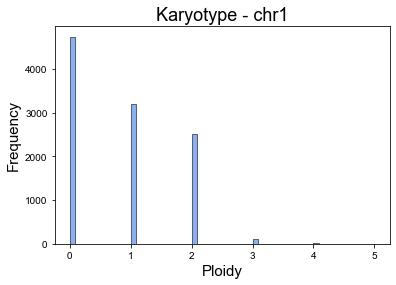

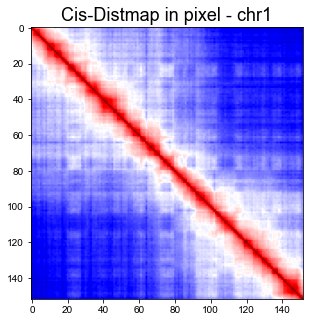

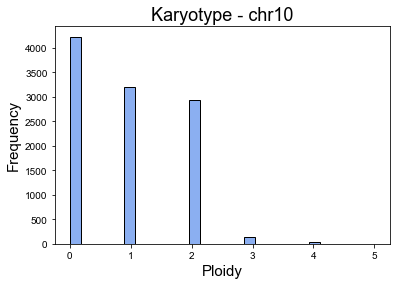

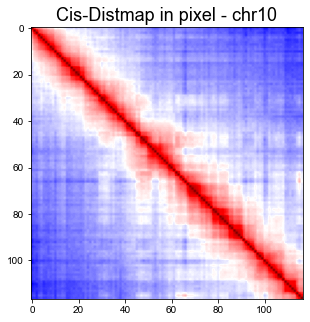

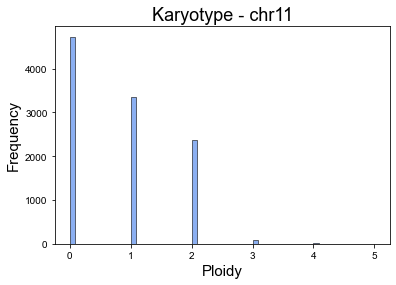

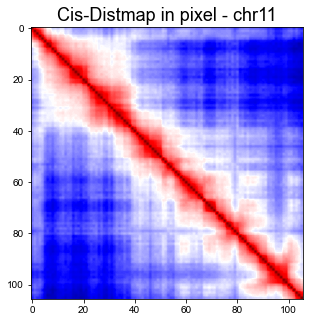

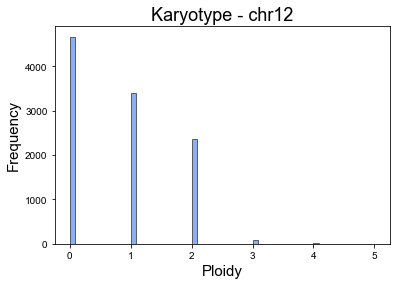

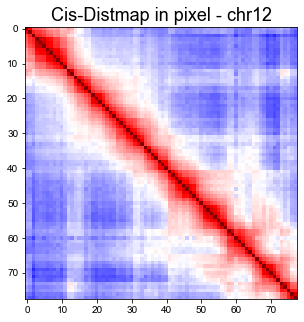

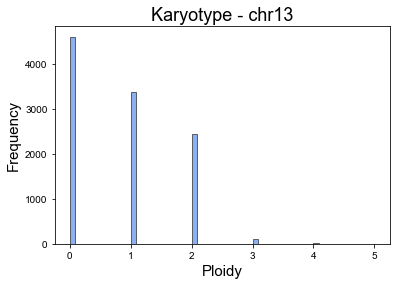

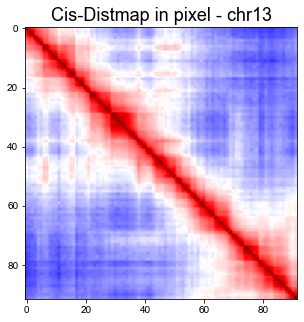

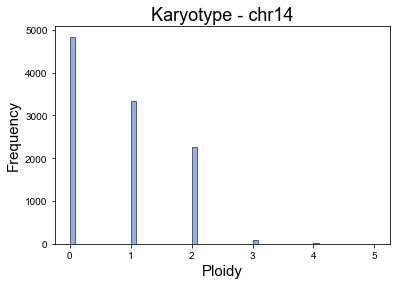

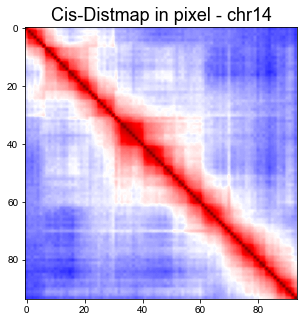

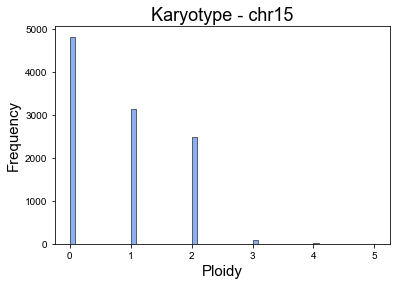

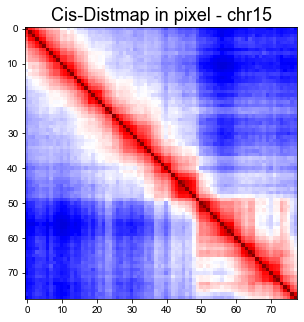

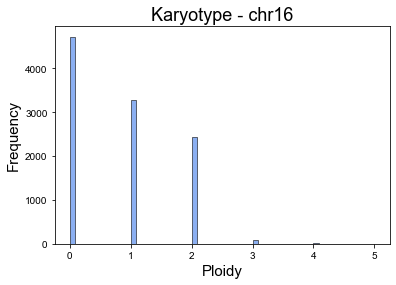

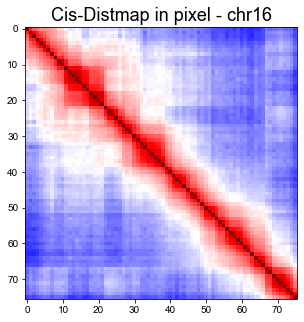

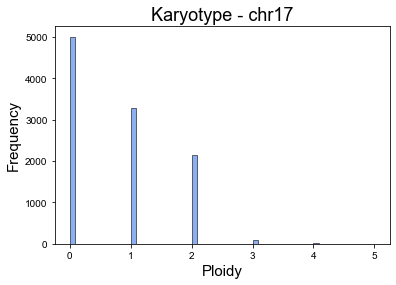

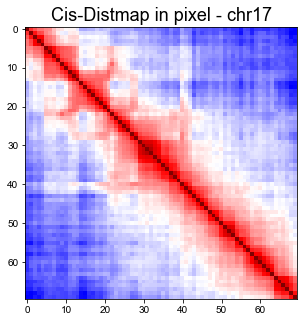

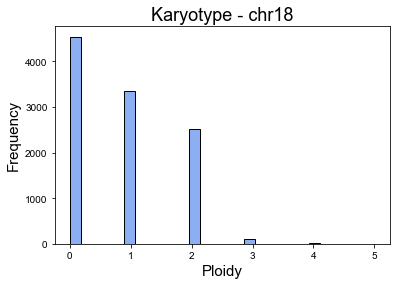

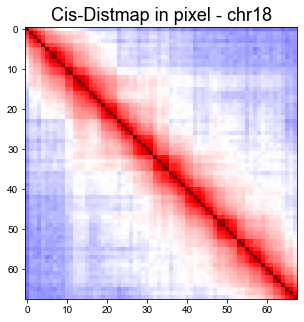

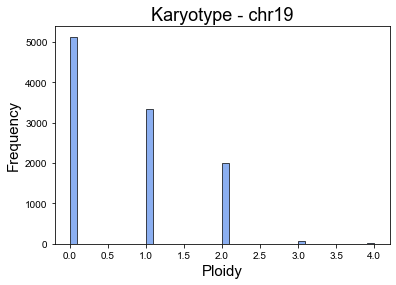

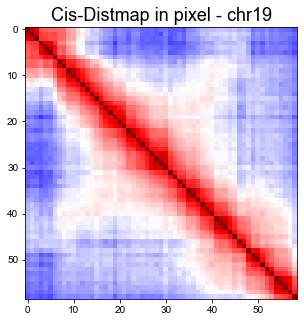

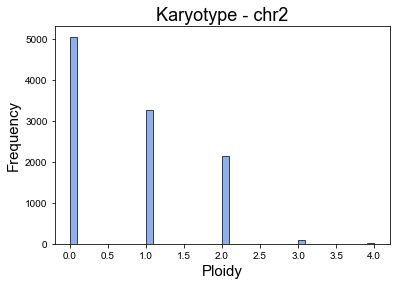

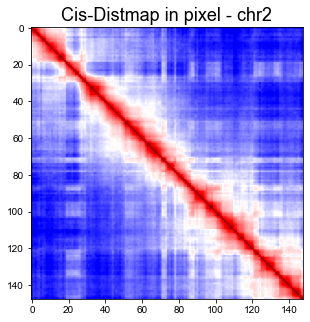

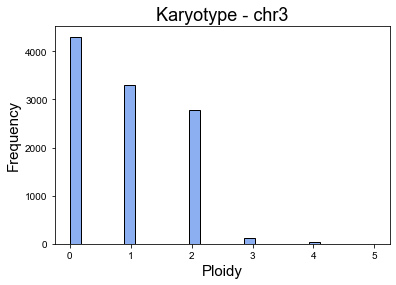

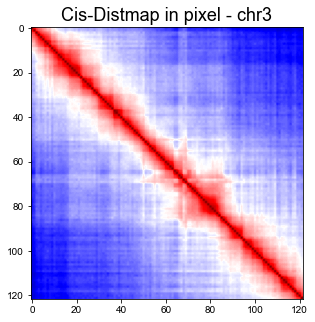

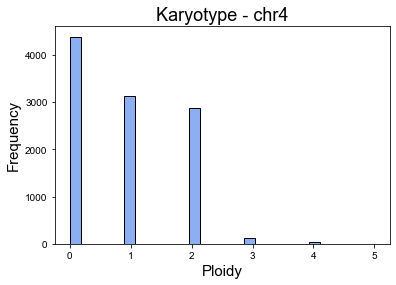

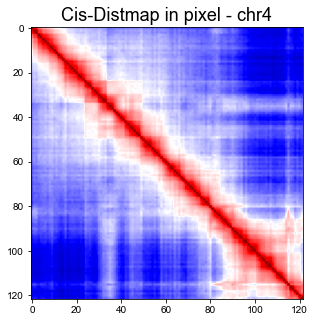

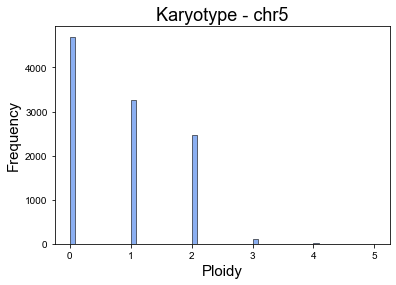

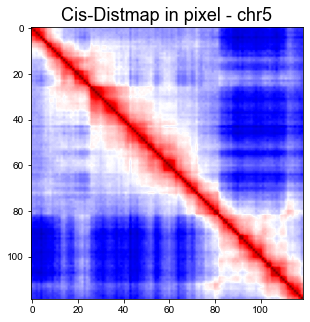

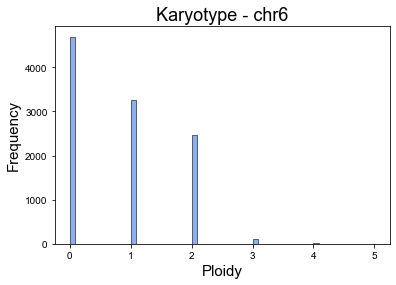

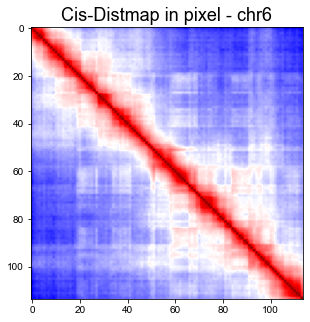

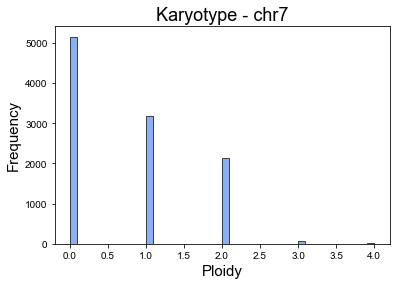

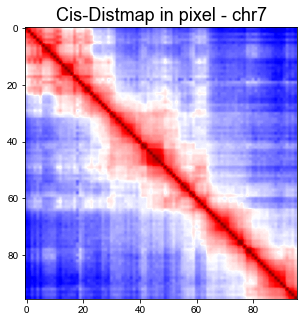

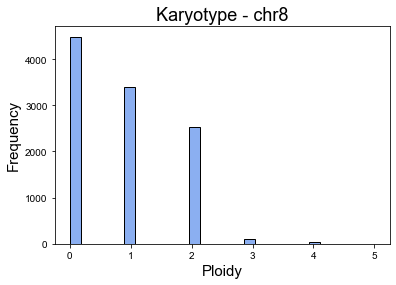

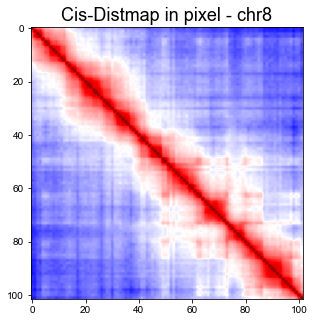

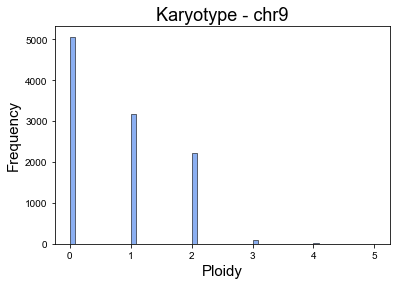

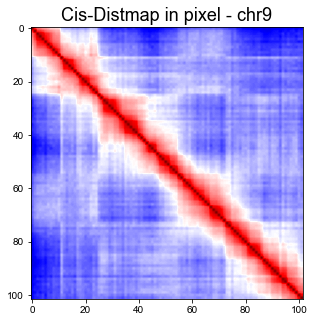

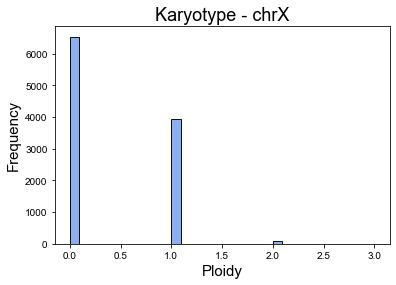

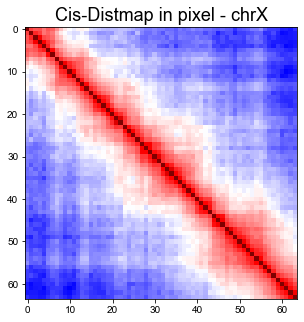

In [25]:
# pick spot with given params and plot result
%matplotlib inline

_save_pick = True

sel_celltypes = np.unique(chr_pts['celltype'])

if __name__ == '__main__':
    
    #for chosen_chrom in params.keys():
    for chosen_chrom in sel_chrom_keys:
        
        print(f'Start processing chromosome {chosen_chrom}.')
        
        print(f'Loading shared parameters as: num_skip:{num_skip}, isf:{isf},tsf:{tsf},nm_per_bp:{nm_per_bp}.')
        ####################################################
        # pick spots for each chr-fiber with mp of each cell
        # grab candidate coordinates
        sel_chr_pts = chr_pts[(chr_pts['celltype'].isin(sel_celltypes)) &
                              (chr_pts['chr'] == chosen_chrom)]['data'].tolist()
        
        # additional clean up for chr1 and chr3 
        if chosen_chrom in ['chr1','chr3']:
            redun_hyb_pair = redun_hyb_dict[chosen_chrom]
            sel_chr_pts_clean=[]
            for _chr_pt in sel_chr_pts:
                sel_chr_pts_clean.append(process_redun_hyb_df (_chr_pt, redun_hyb_pair, hyb_col = 'hyb', drop_redun = False))
            sel_chr_pts=sel_chr_pts_clean

        # grab reference genome (and clean up ref_df if chr1 or chr3)
        df_refgen_chr = df_refgen[df_refgen['chr'] == chosen_chrom]
        if chosen_chrom in ['chr1','chr3']:
            df_refgen_chr = process_redun_hyb_df (df_refgen_chr, redun_hyb_pair, hyb_col = 'hyb', drop_redun = True)
            
        gene_dist = df_refgen_chr['delta']
        # estimate bin size
        loci_starts = df_refgen_chr['start']
        intervals = [j-i for i, j in zip(loci_starts[:-1], loci_starts[1:])]
        bin_size = np.median(intervals)
        
        # set params
        nm_per_bps = [nm_per_bp,] * len(sel_chr_pts)
        #cdfs_threshs = [cdfs_thresh, ] * len(sel_chr_pts)
        num_skips = [num_skip,] * len(sel_chr_pts) 
        bin_sizes = [bin_size,] * len(sel_chr_pts)
        total_num_skip_fracs = [tsf,] * len(sel_chr_pts)
        init_num_skip_fracs = [isf,] * len(sel_chr_pts)
        gene_dists = [gene_dist.values,] * len(sel_chr_pts)
        l_p_bps = [l_p_bp, ] * len(sel_chr_pts)

        start_time = time.time()
            
        with mp.Pool(16) as pick_pool:
            pick_res = pick_pool.starmap(aligner_CW_v2.find_all_chr, zip(sel_chr_pts, gene_dists, bin_sizes,
                                                                      nm_per_bps, num_skips, 
                                                                      total_num_skip_fracs,
                                                                      init_num_skip_fracs, l_p_bps), chunksize=1)
            pick_pool.close()
            pick_pool.join()
            pick_pool.terminate()
        
        elapsed_time = time.time() - start_time
        
        print(f'Finish processing chromosome {chosen_chrom}')
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
        ###################################################
        # report chrom ploidy number, which could used to adjust the nm_per_bp

        karyo_new = [len(elem) for elem in pick_res]
        karyo_new_arr = np.array(karyo_new)
        frac_dip = (np.sum(karyo_new_arr==2)+np.sum(karyo_new_arr==1))/len(karyo_new_arr)
        frac_tri = (np.sum(karyo_new_arr>2)/len(karyo_new_arr))
        print(f'{round(frac_dip*100,1)}% cells have one or two copie(s); and {round(frac_tri*100,1)}% have more than three copies')
        ##############################################
        if not os.path.exists(os.path.join(merged_spot_folder, output_subfolder)):
            os.mkdir(os.path.join(merged_spot_folder, output_subfolder))
        # quick view of the pick info
        # plot ploidy number
        figure_folder = os.path.join(merged_spot_folder,output_subfolder,'figures')
        if not os.path.exists(figure_folder):
            os.mkdir(figure_folder)
        
        fig, axs = plt.subplots(figsize = (6, 4))
        sns.histplot(karyo_new, color='cornflowerblue');
        axs.set_ylabel('Frequency', fontsize = 15)
        axs.set_xlabel('Ploidy', fontsize = 15)
        axs.set_title('Karyotype - {0}'.format(chosen_chrom), fontsize = 18)
        fig.savefig(os.path.join(figure_folder, f"{dna_exp_key}exp_pick_{chosen_chrom}_chr_ploidy.png"))


        # plot distmap
        res_flat = [fiber for cell_res in pick_res for fiber in cell_res]
        med_dist_mat = plot.calc_med_dist_mat(res_flat, len(gene_dist))
        fig, axs = plt.subplots(figsize = (5, 5))
        axs.imshow(med_dist_mat*100, cmap = 'seismic_r', vmin=0, vmax = 3000)
        axs.set_title('Cis-Distmap in pixel - {0}'.format(chosen_chrom), fontsize = 18)
        fig.savefig(os.path.join(figure_folder, f"{dna_exp_key}exp_pick_{chosen_chrom}_distmap.png"))


        ###################################################
        # save individual df and concat
        if _save_pick:
            _res_flat_list = []
            # each cell
            for  _res in pick_res:
                # each fiber haploid
                if len(_res)>0:
                    for _fiber_ind, _fiber in enumerate(_res):
                        _fiber['fiberidx']=_fiber_ind+1
                        _res_flat_list.append(_fiber)
            merged_pick_res =  pd.concat(_res_flat_list)
            # clean up for chr1 or chr3
            if chosen_chrom in ['chr1','chr3']:
                merged_pick_res['hyb']=merged_pick_res['hyb_copy']
                merged_pick_res=merged_pick_res.drop(columns=['hyb_copy'])
                
            outputfile_name = f'{dna_exp_key}exp_pick_{chosen_chrom}'+'.h5'
            outputfile = os.path.join(merged_spot_folder, output_subfolder, outputfile_name)
            merged_pick_res.to_hdf(outputfile, key='df', mode='w')
            del(_res_flat_list)
            del(merged_pick_res)
            print(f'Finish saving chromosome {chosen_chrom}.')
            print(f'+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

In [26]:
del(chr_pts)

## 5.3 Experiment 20220419

### (a) Load spot df from individual replicate

In [27]:
# exp folder
exp_key_order = 2 
dna_exp_key = dna_exp_key_list[exp_key_order]
dna_exp_key

'20220419'

In [28]:
# concat all converted spot dataframes

merged_spot_folder=os.path.join(merged_spot_main_folder,f'{dna_exp_key}exp')

df_list = []
#for _ct in tqdm([0,1,2,3,4,5]):
for _ct in tqdm.tqdm(list(range(0,30))):
    coord_df_exp_subfname = os.path.join(merged_spot_folder, f'{dna_exp_key}exp_cand_spots_part{_ct}.csv')
    if os.path.exists(coord_df_exp_subfname):
        df_list.append(pd.read_csv(coord_df_exp_subfname))
    #print(_ids)
spot_dfs = pd.concat(df_list)
##############################################################
# add uid as finalCellID for picking by cell

spot_FovCell_list = []
#for Fov_id, Cell_id in tqdm(zip(df_4dn['FOV'],df_4dn['orig_cellID'])):
for Fov_id, Cell_id in tqdm.tqdm(zip(spot_dfs['FOV'],spot_dfs['orig_cellID'])):
    spot_FovCell_list.append(ExpFovCell_2_uid_from_FovCell (str(Fov_id), 
                                                            Cell_id.split('Cell-')[1], 
                                                            ExpFovCell_2_uid, Exp_name=rna_exp_names[exp_key_order]))
#df_4dn['Cell_ID'] = df_4dn.apply(lambda x: ExpFovCell_2_uid_from_FovCell(x['FOV'],x['orig_cellID'],ExpFovCell_2_uid),axis=1)
spot_dfs['finalcellID']=spot_FovCell_list

# add chr to num if not done so yet
if 'chr' not in spot_dfs['chr'].tolist()[0]:
    spot_dfs['chr'] = spot_dfs['chr'].apply(lambda x: 'chr'+x)

##################################################################
# clean up spot df
spot_dfs.reset_index(inplace=True)
spot_dfs['rowID'] = spot_dfs.index
spot_dfs=spot_dfs.drop(columns='level_0')
spot_dfs.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:11<00:00,  6.38s/it]
53707713it [00:43, 1241894.74it/s]


region_name    chr      start        end      z_hat       x_hat  \
0    10:63740897-63756638  chr10   63740897   63756638  32.118079  274.702317   
1    17:66251012-66259999  chr17   66251012   66259999  67.742495  257.792930   
2    14:98743990-98754461  chr14   98743990   98754461  42.239278  272.979940   
3  12:108750719-108759995  chr12  108750719  108759995   7.880886  282.390057   
4   4:133752743-133759986   chr4  133752743  133759986  55.271634  287.495480   

        y_hat  center_intensity  center_internal_dist codebook_name  ...  \
0  495.865053       4298.571033            177.601734         CTP11  ...   
1  469.682857       3916.008767            122.073367         CTP11  ...   
2  471.814993       4558.124433             33.697365         CTP11  ...   
3  482.615197       7113.342833            219.068842         CTP11  ...   
4  470.419577       8573.163533             82.841062         CTP11  ...   

  orig_cellID  FOV  replicate  sig_x sig_y sig_z  hyb  celltype  \
0     Cell-10    0   20220419      1     1     1   52     Micro   
1     Cell-10    0   20220419      1     1     1   47     Micro   
2     Cell-10    0   20220419      1     1     1   72     Micro   
3     Cell-10    0   20220419      1     1     1   68     Micro   
4     Cell-10    0   20220419      1     1     1  109     Micro   

                               finalcellID  rowID  
0  111675560143164484725982771322272043071      0  
1  111675560143164484725982771322272043071      1  
2  111675560143164484725982771322272043071      2  
3  111675560143164484725982771322272043071      3  
4  111675560143164484725982771322272043071      4  

[5 rows x 25 columns]

### (b) Pick spots using jie_CW

In [29]:
# save results into chr_pts format
chr_pts = {'replicate': {},
           'FOV': {},
           'orig_cellID': {},
           'finalcellID': {},
           'celltype': {},
           'chr': {},
           'data': {}}



# group by celltype, chr, finalcellD
for i, (name, group) in tqdm.tqdm(enumerate(spot_dfs.groupby(by=['celltype', 'chr', 'finalcellID']))):
            
    # make copy
    _df_cell = copy.deepcopy(group)
    
    # drop columns
    _df_cell = _df_cell[['replicate', 'FOV', 'orig_cellID', 'finalcellID',  
                         'celltype','chr', 'hyb', 'region_name', 
                         'x_hat', 'y_hat', 'z_hat', 
                         'sig_x', 'sig_y', 'sig_z','rowID']]

    # sort by hyb_rnd
    _df_cell = _df_cell.sort_values(by=['hyb'])

    # reset index
    _df_cell.reset_index(inplace=True, drop = True)

    # save df
    chr_pts['replicate'][i] = _df_cell.iloc[0]['replicate']
    chr_pts['FOV'][i] = _df_cell.iloc[0]['FOV']
    chr_pts['orig_cellID'][i] = _df_cell.iloc[0]['orig_cellID']
    chr_pts['finalcellID'][i] = _df_cell.iloc[0]['finalcellID']
    chr_pts['celltype'][i] = _df_cell.iloc[0]['celltype']
    chr_pts['chr'][i] = _df_cell.iloc[0]['chr']
    chr_pts['data'][i] = _df_cell

    
del spot_dfs
chr_pts = pd.DataFrame(chr_pts)
chr_pts.head()

299752it [05:00, 996.93it/s] 


replicate  FOV orig_cellID                              finalcellID  \
0   20220419  100     Cell-60  100207908400460076830780865652854694913   
1   20220419  157     Cell-10  100267022990578563888527231462820232415   
2   20220419  159    Cell-106  100321527859767693336740091442803176609   
3   20220419   79    Cell-126  100435464305028575409376721347352292104   
4   20220419   34     Cell-10  100659394526758866577081138601060803541   

  celltype   chr                                               data  
0    Astro  chr1      replicate  FOV orig_cellID                ...  
1    Astro  chr1      replicate  FOV orig_cellID                ...  
2    Astro  chr1       replicate  FOV orig_cellID               ...  
3    Astro  chr1      replicate  FOV orig_cellID                ...  
4    Astro  chr1       replicate  FOV orig_cellID               ...

In [30]:
num_skip = 7
nm_per_bp = 0.3
isf = 0.2
tsf = 0.6
l_p_bp = 150

sel_chrom_keys = [chrom for chrom in np.unique(df_refgen.chr.values) if ('Y' not in chrom)]

Start processing chromosome chr1.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr1
00:25:28.26
45.9% cells have one or two copie(s); and 0.4% have more than three copies
Finish saving chromosome chr1.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr10.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr10
00:18:40.75
50.7% cells have one or two copie(s); and 0.7% have more than three copies
Finish saving chromosome chr10.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr11.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr11
00:16:25.58
48.5% cells have one or two copie(s); and 0.6% have more than three copies
Finish saving chromosome chr11.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

C:\Users\cosmosyw\AppData\Local\Temp\ipykernel_24176\2090130925.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (6, 4))


Finish saving chromosome chr19.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr2.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr2
00:24:29.72
42.7% cells have one or two copie(s); and 0.4% have more than three copies
Finish saving chromosome chr2.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr3.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr3
00:19:47.97
49.1% cells have one or two copie(s); and 0.5% have more than three copies
Finish saving chromosome chr3.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr4.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr4
00:19:30.66
50.3% cells have one or two copie(s); and 0.6% have more than three c

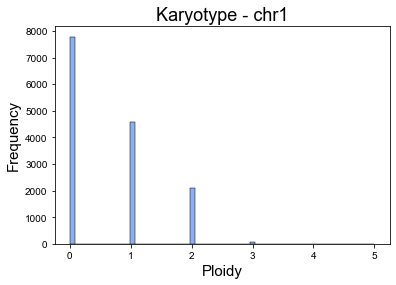

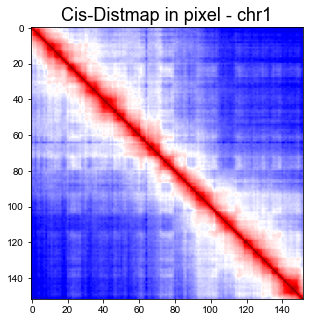

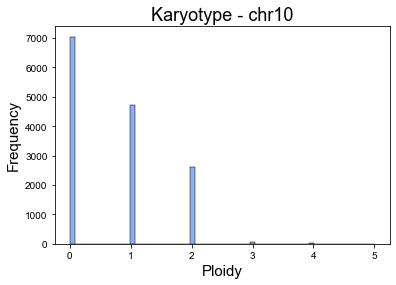

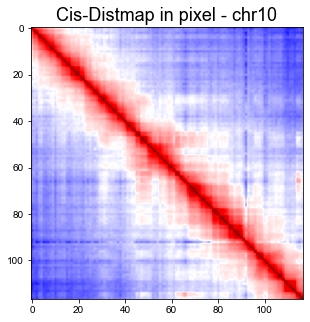

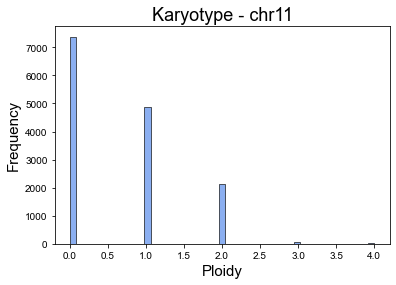

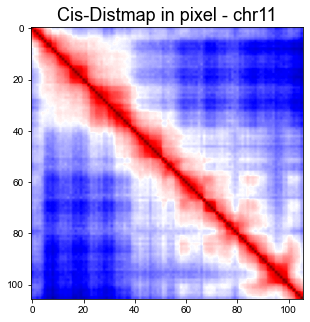

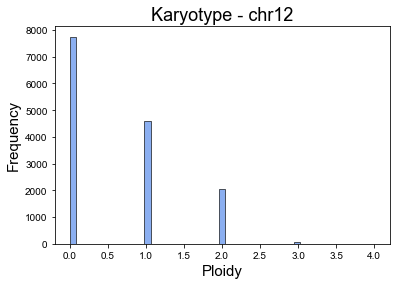

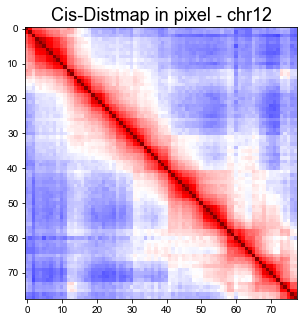

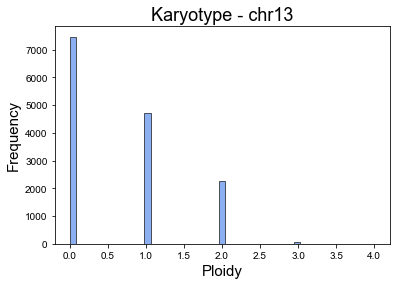

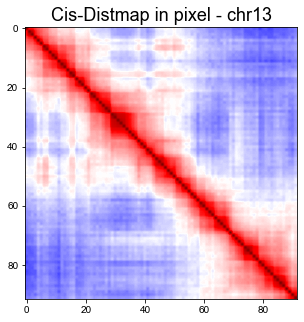

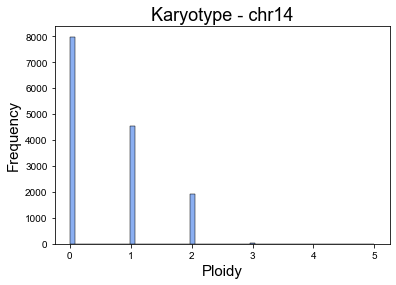

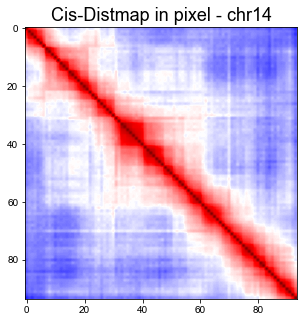

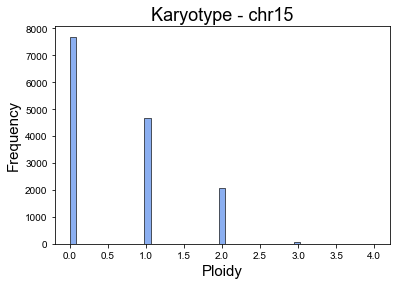

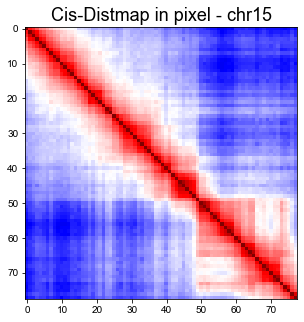

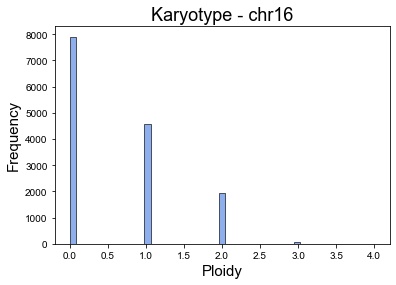

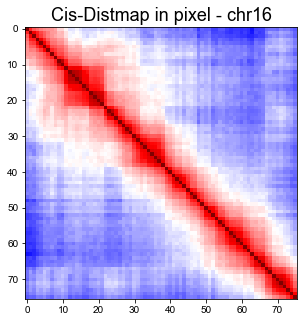

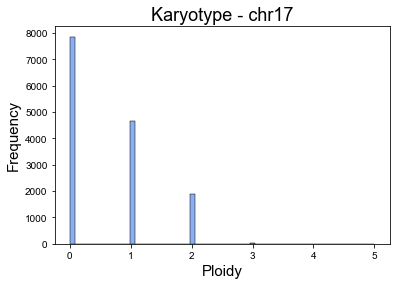

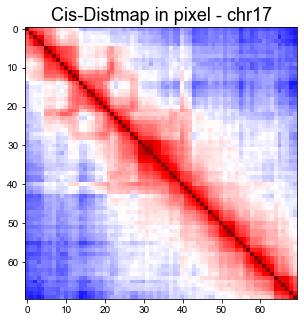

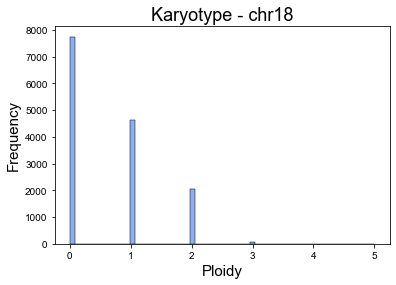

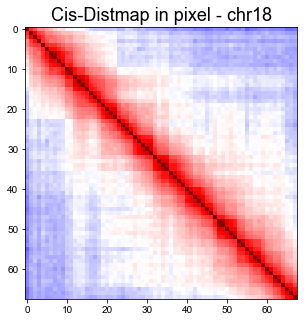

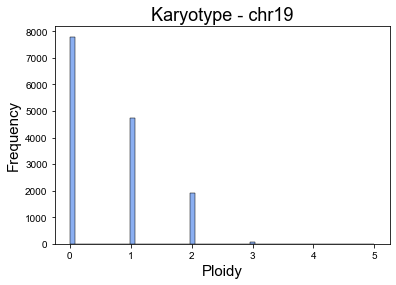

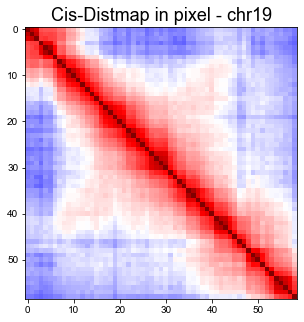

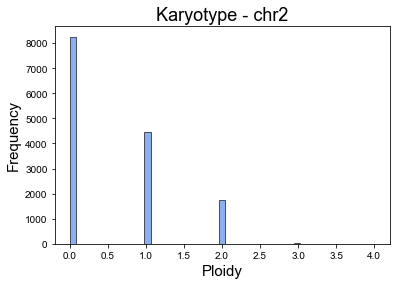

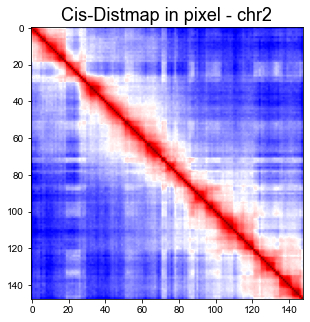

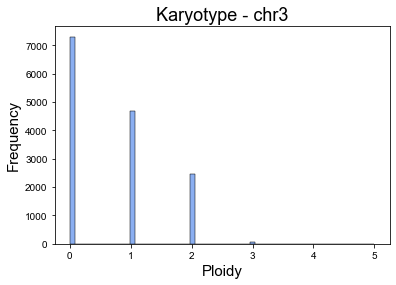

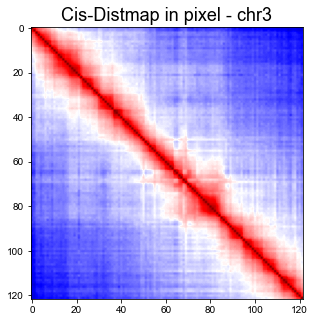

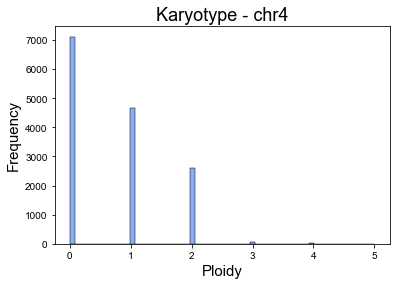

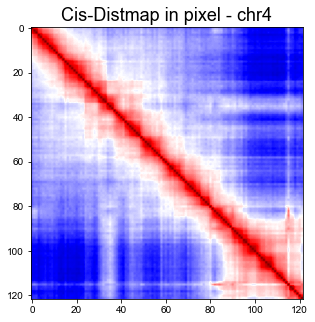

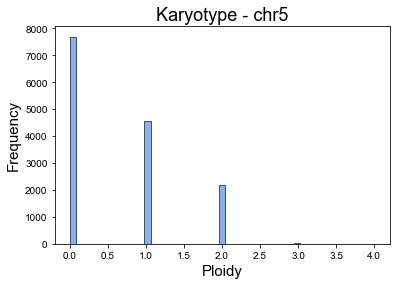

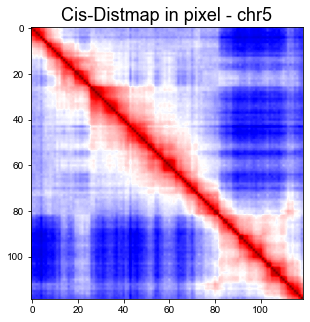

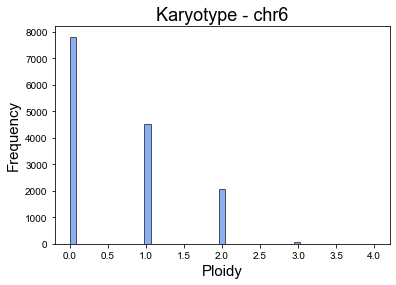

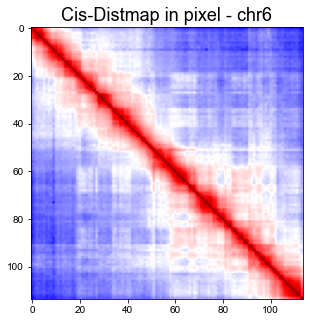

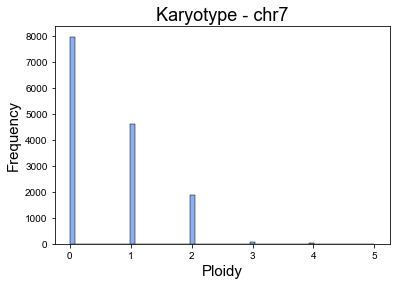

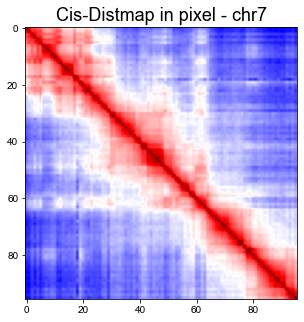

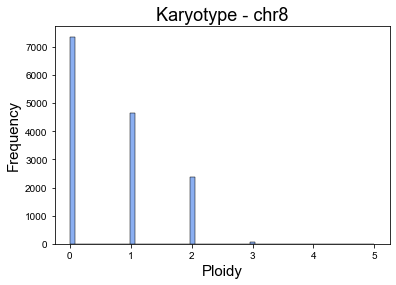

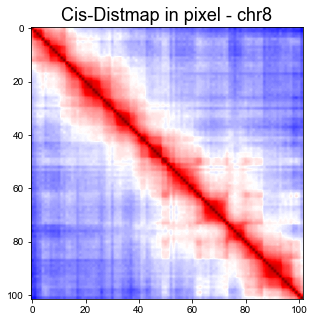

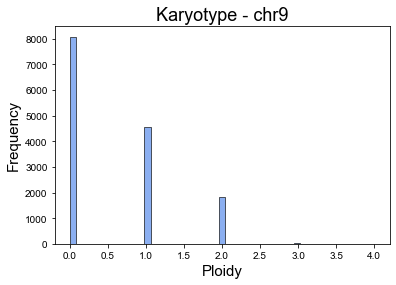

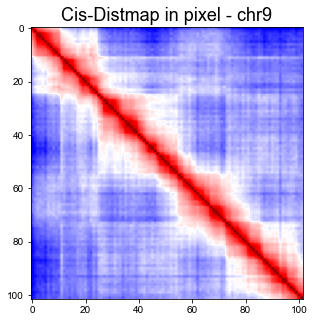

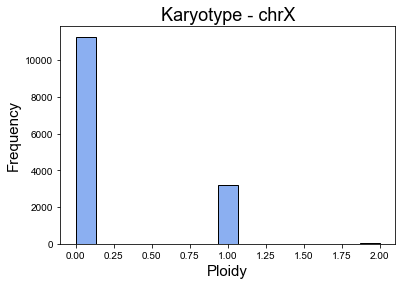

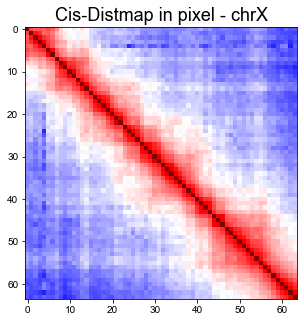

In [31]:
# pick spot with given params and plot result
%matplotlib inline

_save_pick = True

sel_celltypes = np.unique(chr_pts['celltype'])

if __name__ == '__main__':
    
    #for chosen_chrom in params.keys():
    for chosen_chrom in sel_chrom_keys:
        
        print(f'Start processing chromosome {chosen_chrom}.')
        
        print(f'Loading shared parameters as: num_skip:{num_skip}, isf:{isf},tsf:{tsf},nm_per_bp:{nm_per_bp}.')
        ####################################################
        # pick spots for each chr-fiber with mp of each cell
        # grab candidate coordinates
        sel_chr_pts = chr_pts[(chr_pts['celltype'].isin(sel_celltypes)) &
                              (chr_pts['chr'] == chosen_chrom)]['data'].tolist()
        
        # additional clean up for chr1 and chr3 
        if chosen_chrom in ['chr1','chr3']:
            redun_hyb_pair = redun_hyb_dict[chosen_chrom]
            sel_chr_pts_clean=[]
            for _chr_pt in sel_chr_pts:
                sel_chr_pts_clean.append(process_redun_hyb_df (_chr_pt, redun_hyb_pair, hyb_col = 'hyb', drop_redun = False))
            sel_chr_pts=sel_chr_pts_clean

        # grab reference genome (and clean up ref_df if chr1 or chr3)
        df_refgen_chr = df_refgen[df_refgen['chr'] == chosen_chrom]
        if chosen_chrom in ['chr1','chr3']:
            df_refgen_chr = process_redun_hyb_df (df_refgen_chr, redun_hyb_pair, hyb_col = 'hyb', drop_redun = True)
            
        gene_dist = df_refgen_chr['delta']
        # estimate bin size
        loci_starts = df_refgen_chr['start']
        intervals = [j-i for i, j in zip(loci_starts[:-1], loci_starts[1:])]
        bin_size = np.median(intervals)
        
        # set params
        nm_per_bps = [nm_per_bp,] * len(sel_chr_pts)
        #cdfs_threshs = [cdfs_thresh, ] * len(sel_chr_pts)
        num_skips = [num_skip,] * len(sel_chr_pts) 
        bin_sizes = [bin_size,] * len(sel_chr_pts)
        total_num_skip_fracs = [tsf,] * len(sel_chr_pts)
        init_num_skip_fracs = [isf,] * len(sel_chr_pts)
        gene_dists = [gene_dist.values,] * len(sel_chr_pts)
        l_p_bps = [l_p_bp, ] * len(sel_chr_pts)

        start_time = time.time()
            
        with mp.Pool(16) as pick_pool:
            pick_res = pick_pool.starmap(aligner_CW_v2.find_all_chr, zip(sel_chr_pts, gene_dists, bin_sizes,
                                                                      nm_per_bps, num_skips, 
                                                                      total_num_skip_fracs,
                                                                      init_num_skip_fracs, l_p_bps), chunksize=1)
            pick_pool.close()
            pick_pool.join()
            pick_pool.terminate()
        
        elapsed_time = time.time() - start_time
        
        print(f'Finish processing chromosome {chosen_chrom}')
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
        ###################################################
        # report chrom ploidy number, which could used to adjust the nm_per_bp

        karyo_new = [len(elem) for elem in pick_res]
        karyo_new_arr = np.array(karyo_new)
        frac_dip = (np.sum(karyo_new_arr==2)+np.sum(karyo_new_arr==1))/len(karyo_new_arr)
        frac_tri = (np.sum(karyo_new_arr>2)/len(karyo_new_arr))
        print(f'{round(frac_dip*100,1)}% cells have one or two copie(s); and {round(frac_tri*100,1)}% have more than three copies')
        ##############################################
        if not os.path.exists(os.path.join(merged_spot_folder, output_subfolder)):
            os.mkdir(os.path.join(merged_spot_folder, output_subfolder))
        # quick view of the pick info
        # plot ploidy number
        figure_folder = os.path.join(merged_spot_folder,output_subfolder,'figures')
        if not os.path.exists(figure_folder):
            os.mkdir(figure_folder)
        
        fig, axs = plt.subplots(figsize = (6, 4))
        sns.histplot(karyo_new, color='cornflowerblue');
        axs.set_ylabel('Frequency', fontsize = 15)
        axs.set_xlabel('Ploidy', fontsize = 15)
        axs.set_title('Karyotype - {0}'.format(chosen_chrom), fontsize = 18)
        fig.savefig(os.path.join(figure_folder, f"{dna_exp_key}exp_pick_{chosen_chrom}_chr_ploidy.png"))


        # plot distmap
        res_flat = [fiber for cell_res in pick_res for fiber in cell_res]
        med_dist_mat = plot.calc_med_dist_mat(res_flat, len(gene_dist))
        fig, axs = plt.subplots(figsize = (5, 5))
        axs.imshow(med_dist_mat*100, cmap = 'seismic_r', vmin=0, vmax = 3000)
        axs.set_title('Cis-Distmap in pixel - {0}'.format(chosen_chrom), fontsize = 18)
        fig.savefig(os.path.join(figure_folder, f"{dna_exp_key}exp_pick_{chosen_chrom}_distmap.png"))


        ###################################################
        # save individual df and concat
        if _save_pick:
            _res_flat_list = []
            # each cell
            for  _res in pick_res:
                # each fiber haploid
                if len(_res)>0:
                    for _fiber_ind, _fiber in enumerate(_res):
                        _fiber['fiberidx']=_fiber_ind+1
                        _res_flat_list.append(_fiber)
            merged_pick_res =  pd.concat(_res_flat_list)
            # clean up for chr1 or chr3
            if chosen_chrom in ['chr1','chr3']:
                merged_pick_res['hyb']=merged_pick_res['hyb_copy']
                merged_pick_res=merged_pick_res.drop(columns=['hyb_copy'])
                
            outputfile_name = f'{dna_exp_key}exp_pick_{chosen_chrom}'+'.h5'
            outputfile = os.path.join(merged_spot_folder, output_subfolder, outputfile_name)
            merged_pick_res.to_hdf(outputfile, key='df', mode='w')
            del(_res_flat_list)
            del(merged_pick_res)
            print(f'Finish saving chromosome {chosen_chrom}.')
            print(f'+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

In [32]:
del(chr_pts)

## 5.4 Experiment 20220713

### (a) Load spot df from individual replicate

In [33]:
# exp folder
exp_key_order = 3 
dna_exp_key = dna_exp_key_list[exp_key_order]
dna_exp_key

'20220713'

In [34]:
# concat all converted spot dataframes

merged_spot_folder=os.path.join(merged_spot_main_folder,f'{dna_exp_key}exp')

df_list = []
#for _ct in tqdm([0,1,2,3,4,5]):
for _ct in tqdm.tqdm(list(range(0,30))):
    coord_df_exp_subfname = os.path.join(merged_spot_folder, f'{dna_exp_key}exp_cand_spots_part{_ct}.csv')
    if os.path.exists(coord_df_exp_subfname):
        df_list.append(pd.read_csv(coord_df_exp_subfname))
    #print(_ids)
spot_dfs = pd.concat(df_list)
##############################################################
# add uid as finalCellID for picking by cell

spot_FovCell_list = []
#for Fov_id, Cell_id in tqdm(zip(df_4dn['FOV'],df_4dn['orig_cellID'])):
for Fov_id, Cell_id in tqdm.tqdm(zip(spot_dfs['FOV'],spot_dfs['orig_cellID'])):
    spot_FovCell_list.append(ExpFovCell_2_uid_from_FovCell (str(Fov_id), 
                                                            Cell_id.split('Cell-')[1], 
                                                            ExpFovCell_2_uid, Exp_name=rna_exp_names[exp_key_order]))
#df_4dn['Cell_ID'] = df_4dn.apply(lambda x: ExpFovCell_2_uid_from_FovCell(x['FOV'],x['orig_cellID'],ExpFovCell_2_uid),axis=1)
spot_dfs['finalcellID']=spot_FovCell_list

# add chr to num if not done so yet
if 'chr' not in spot_dfs['chr'].tolist()[0]:
    spot_dfs['chr'] = spot_dfs['chr'].apply(lambda x: 'chr'+x)

##################################################################
# clean up spot df
spot_dfs.reset_index(inplace=True)
spot_dfs['rowID'] = spot_dfs.index
spot_dfs=spot_dfs.drop(columns='level_0')
spot_dfs.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:18<00:00,  4.60s/it]
48158419it [00:38, 1251922.71it/s]


region_name    chr      start        end      z_hat        x_hat  \
0  2:118752499-118759998   chr2  118752499  118759998  47.584532  1944.722033   
1    1:98745311-98760001   chr1   98745311   98760001  58.418464  1918.532400   
2    1:91252155-91259954   chr1   91252155   91259954  45.063659  1951.180900   
3   12:91250550-91260000  chr12   91250550   91260000  55.358685  1930.498000   
4    6:11243080-11259954   chr6   11243080   11259954  70.435910  1922.098100   

         y_hat  center_intensity  center_internal_dist codebook_name  ...  \
0  1211.474333       6591.914800             34.285072         CTP11  ...   
1  1201.448600       8467.012367             44.253711         CTP11  ...   
2  1224.230067       6844.794600             53.030451         CTP11  ...   
3  1168.828767       4946.581300             53.367581         CTP11  ...   
4  1210.672100       6769.501667            171.293833         CTP11  ...   

  orig_cellID  FOV  replicate  sig_x sig_y  sig_z  hyb  celltype  \
0    Cell-102    0   20220419      1     1      1   86     Oligo   
1    Cell-102    0   20220419      1     1      1   83     Oligo   
2    Cell-102    0   20220419      1     1      1   77     Oligo   
3    Cell-102    0   20220419      1     1      1   62     Oligo   
4    Cell-102    0   20220419      1     1      1    6     Oligo   

                               finalcellID  rowID  
0  305592933172988708178020786168731191582      0  
1  305592933172988708178020786168731191582      1  
2  305592933172988708178020786168731191582      2  
3  305592933172988708178020786168731191582      3  
4  305592933172988708178020786168731191582      4  

[5 rows x 24 columns]

### (b) Pick spots using jie_CW

In [35]:
# save results into chr_pts format
chr_pts = {'replicate': {},
           'FOV': {},
           'orig_cellID': {},
           'finalcellID': {},
           'celltype': {},
           'chr': {},
           'data': {}}



# group by celltype, chr, finalcellD
for i, (name, group) in tqdm.tqdm(enumerate(spot_dfs.groupby(by=['celltype', 'chr', 'finalcellID']))):
            
    # make copy
    _df_cell = copy.deepcopy(group)
    
    # drop columns
    _df_cell = _df_cell[['replicate', 'FOV', 'orig_cellID', 'finalcellID',  
                         'celltype','chr', 'hyb', 'region_name', 
                         'x_hat', 'y_hat', 'z_hat', 
                         'sig_x', 'sig_y', 'sig_z','rowID']]

    # sort by hyb_rnd
    _df_cell = _df_cell.sort_values(by=['hyb'])

    # reset index
    _df_cell.reset_index(inplace=True, drop = True)

    # save df
    chr_pts['replicate'][i] = _df_cell.iloc[0]['replicate']
    chr_pts['FOV'][i] = _df_cell.iloc[0]['FOV']
    chr_pts['orig_cellID'][i] = _df_cell.iloc[0]['orig_cellID']
    chr_pts['finalcellID'][i] = _df_cell.iloc[0]['finalcellID']
    chr_pts['celltype'][i] = _df_cell.iloc[0]['celltype']
    chr_pts['chr'][i] = _df_cell.iloc[0]['chr']
    chr_pts['data'][i] = _df_cell

    
del spot_dfs
chr_pts = pd.DataFrame(chr_pts)
chr_pts.head()

244313it [04:07, 987.59it/s] 


replicate  FOV orig_cellID                              finalcellID  \
0   20220713  172     Cell-94  100293191333250630141497927255318731543   
1   20220713   39    Cell-106  100476475441289743837548046987347241128   
2   20220713   18     Cell-10  100502394973884731031710640222794322905   
3   20220713   14     Cell-43  101137933707551877468034795298833287659   
4   20220713  113     Cell-20  101577612366988214070392584244684457547   

  celltype   chr                                               data  
0    Astro  chr1       replicate  FOV orig_cellID               ...  
1    Astro  chr1      replicate  FOV orig_cellID                ...  
2    Astro  chr1       replicate  FOV orig_cellID               ...  
3    Astro  chr1       replicate  FOV orig_cellID               ...  
4    Astro  chr1       replicate  FOV orig_cellID               ...

In [36]:
num_skip = 7
nm_per_bp = 0.3
isf = 0.2
tsf = 0.6
l_p_bp = 150

sel_chrom_keys = [chrom for chrom in np.unique(df_refgen.chr.values) if ('Y' not in chrom)]

Start processing chromosome chr1.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr1
00:21:15.39
55.5% cells have one or two copie(s); and 1.1% have more than three copies
Finish saving chromosome chr1.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr10.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr10
00:15:43.83
59.7% cells have one or two copie(s); and 1.6% have more than three copies
Finish saving chromosome chr10.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr11.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr11
00:13:39.35
56.5% cells have one or two copie(s); and 1.2% have more than three copies
Finish saving chromosome chr11.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

C:\Users\cosmosyw\AppData\Local\Temp\ipykernel_24176\2090130925.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (6, 4))


Finish saving chromosome chr19.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr2.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr2
00:20:59.51
54.0% cells have one or two copie(s); and 1.1% have more than three copies
Finish saving chromosome chr2.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr3.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr3
00:16:38.90
59.6% cells have one or two copie(s); and 1.3% have more than three copies
Finish saving chromosome chr3.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr4.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.6,nm_per_bp:0.3.
Finish processing chromosome chr4
00:16:18.53
60.0% cells have one or two copie(s); and 1.6% have more than three c

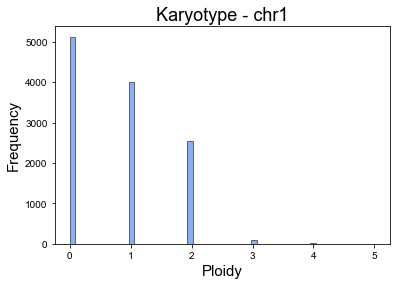

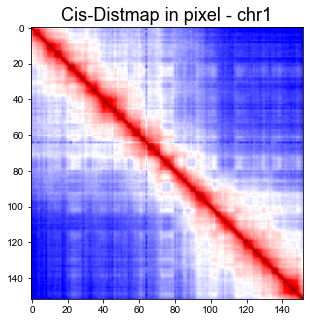

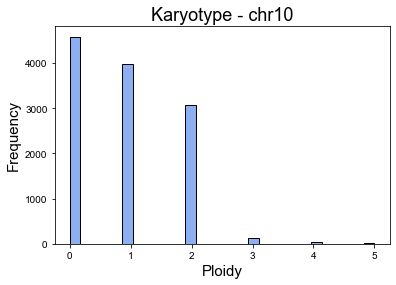

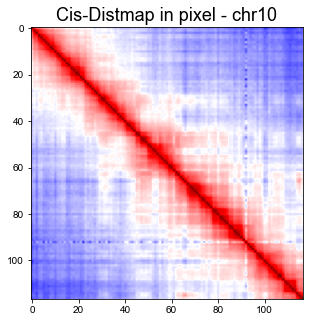

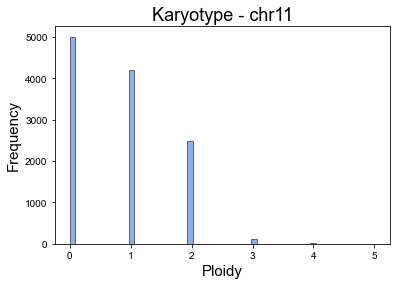

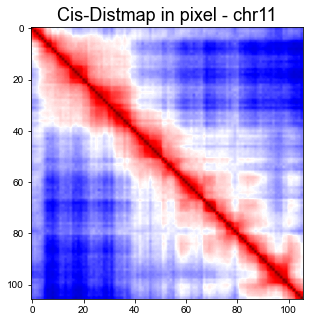

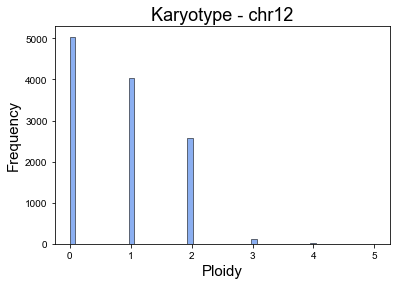

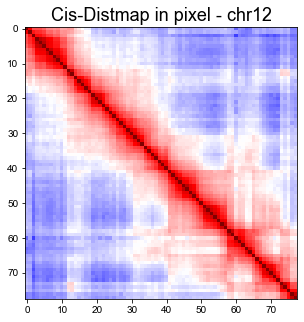

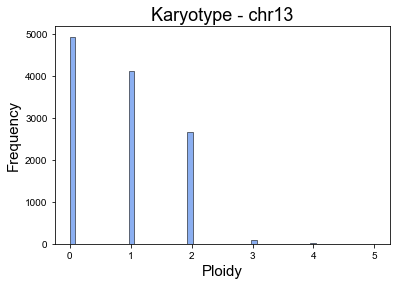

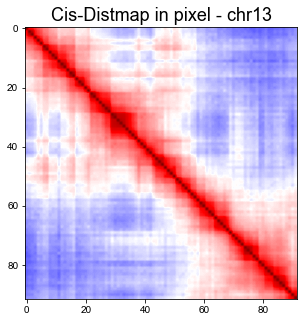

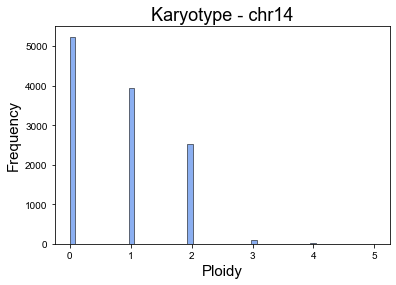

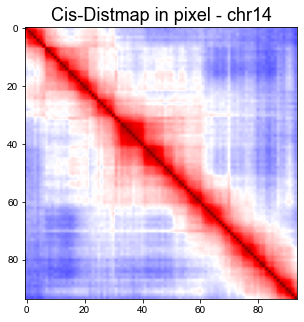

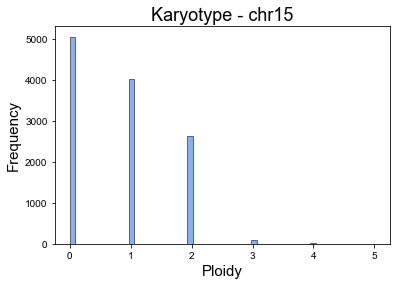

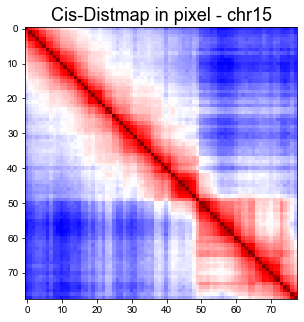

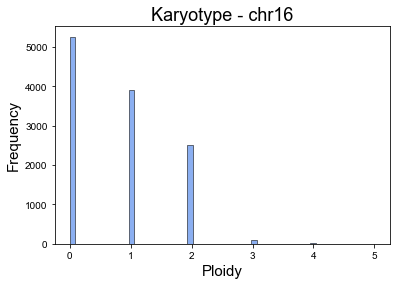

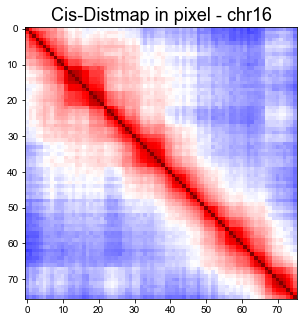

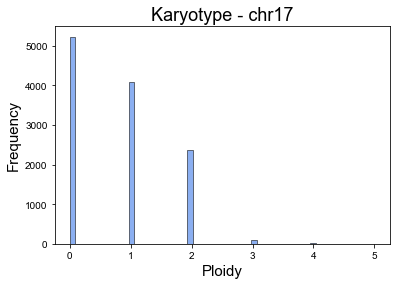

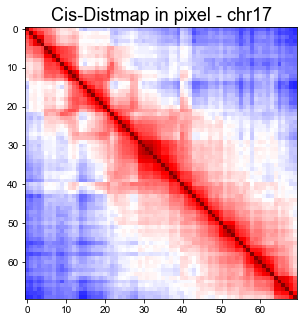

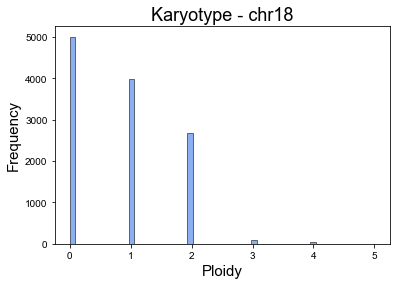

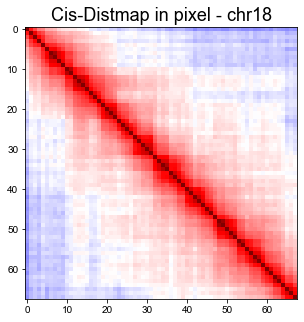

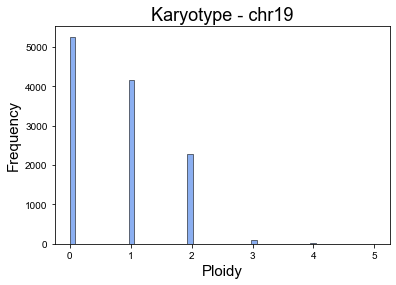

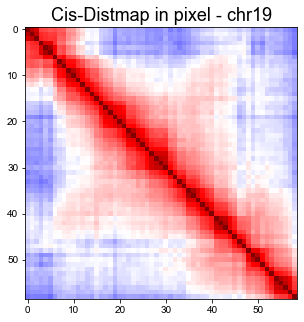

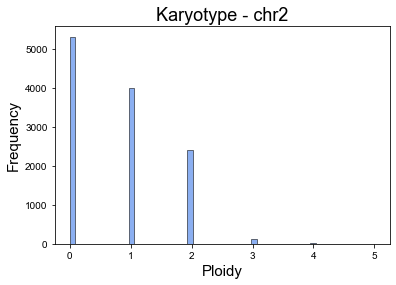

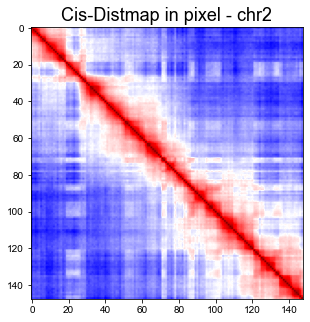

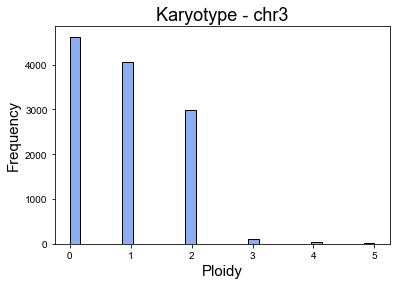

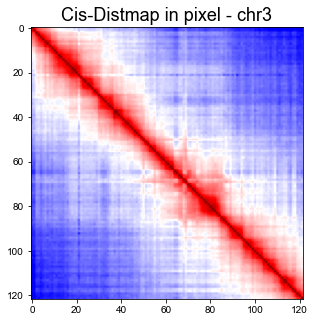

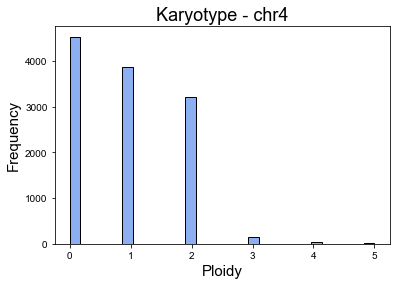

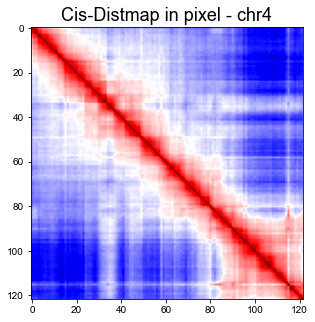

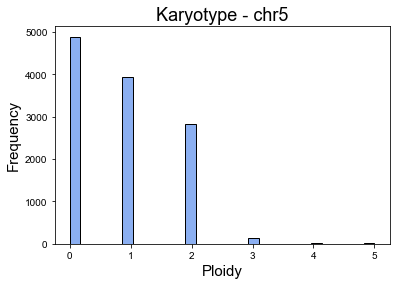

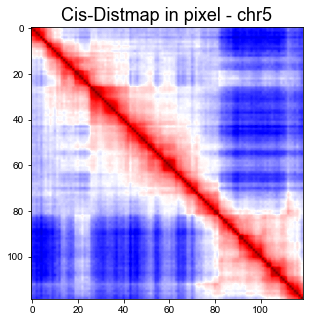

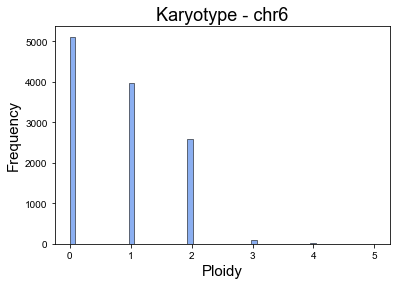

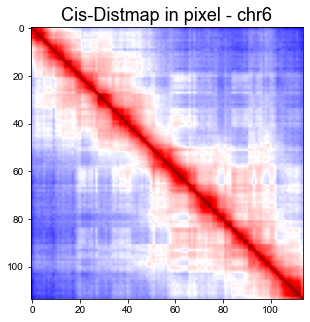

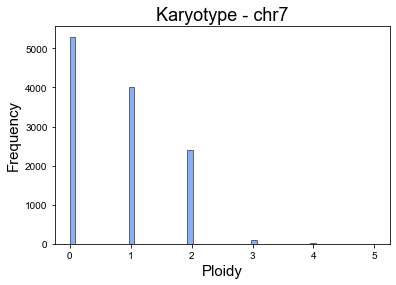

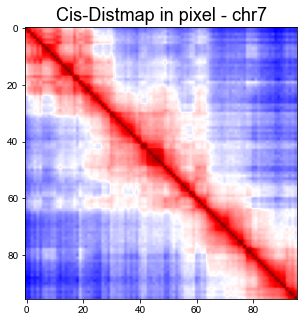

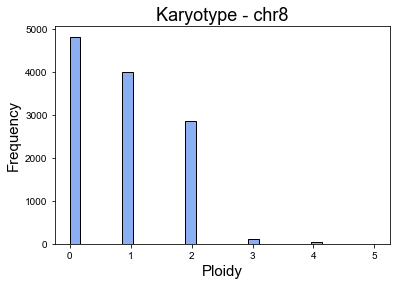

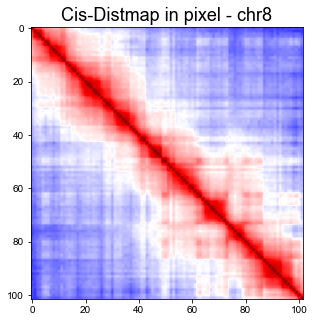

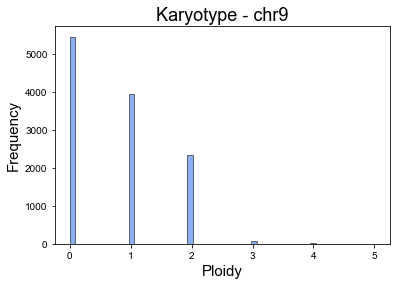

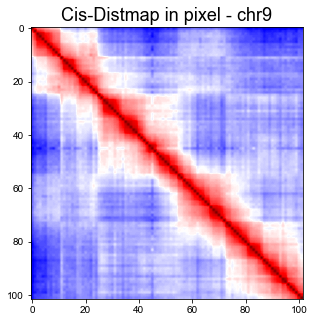

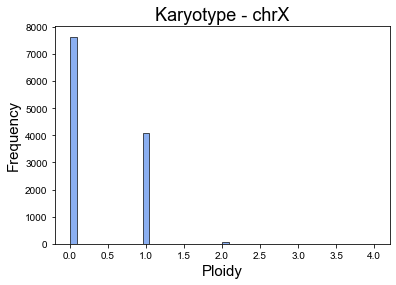

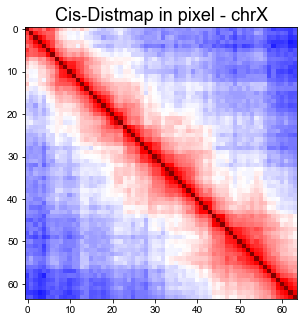

In [37]:
# pick spot with given params and plot result
%matplotlib inline

_save_pick = True

sel_celltypes = np.unique(chr_pts['celltype'])

if __name__ == '__main__':
    
    #for chosen_chrom in params.keys():
    for chosen_chrom in sel_chrom_keys:
        
        print(f'Start processing chromosome {chosen_chrom}.')
        
        print(f'Loading shared parameters as: num_skip:{num_skip}, isf:{isf},tsf:{tsf},nm_per_bp:{nm_per_bp}.')
        ####################################################
        # pick spots for each chr-fiber with mp of each cell
        # grab candidate coordinates
        sel_chr_pts = chr_pts[(chr_pts['celltype'].isin(sel_celltypes)) &
                              (chr_pts['chr'] == chosen_chrom)]['data'].tolist()
        
        # additional clean up for chr1 and chr3 
        if chosen_chrom in ['chr1','chr3']:
            redun_hyb_pair = redun_hyb_dict[chosen_chrom]
            sel_chr_pts_clean=[]
            for _chr_pt in sel_chr_pts:
                sel_chr_pts_clean.append(process_redun_hyb_df (_chr_pt, redun_hyb_pair, hyb_col = 'hyb', drop_redun = False))
            sel_chr_pts=sel_chr_pts_clean

        # grab reference genome (and clean up ref_df if chr1 or chr3)
        df_refgen_chr = df_refgen[df_refgen['chr'] == chosen_chrom]
        if chosen_chrom in ['chr1','chr3']:
            df_refgen_chr = process_redun_hyb_df (df_refgen_chr, redun_hyb_pair, hyb_col = 'hyb', drop_redun = True)
            
        gene_dist = df_refgen_chr['delta']
        # estimate bin size
        loci_starts = df_refgen_chr['start']
        intervals = [j-i for i, j in zip(loci_starts[:-1], loci_starts[1:])]
        bin_size = np.median(intervals)
        
        # set params
        nm_per_bps = [nm_per_bp,] * len(sel_chr_pts)
        #cdfs_threshs = [cdfs_thresh, ] * len(sel_chr_pts)
        num_skips = [num_skip,] * len(sel_chr_pts) 
        bin_sizes = [bin_size,] * len(sel_chr_pts)
        total_num_skip_fracs = [tsf,] * len(sel_chr_pts)
        init_num_skip_fracs = [isf,] * len(sel_chr_pts)
        gene_dists = [gene_dist.values,] * len(sel_chr_pts)
        l_p_bps = [l_p_bp, ] * len(sel_chr_pts)

        start_time = time.time()
            
        with mp.Pool(16) as pick_pool:
            pick_res = pick_pool.starmap(aligner_CW_v2.find_all_chr, zip(sel_chr_pts, gene_dists, bin_sizes,
                                                                      nm_per_bps, num_skips, 
                                                                      total_num_skip_fracs,
                                                                      init_num_skip_fracs, l_p_bps), chunksize=1)
            pick_pool.close()
            pick_pool.join()
            pick_pool.terminate()
        
        elapsed_time = time.time() - start_time
        
        print(f'Finish processing chromosome {chosen_chrom}')
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
        ###################################################
        # report chrom ploidy number, which could used to adjust the nm_per_bp

        karyo_new = [len(elem) for elem in pick_res]
        karyo_new_arr = np.array(karyo_new)
        frac_dip = (np.sum(karyo_new_arr==2)+np.sum(karyo_new_arr==1))/len(karyo_new_arr)
        frac_tri = (np.sum(karyo_new_arr>2)/len(karyo_new_arr))
        print(f'{round(frac_dip*100,1)}% cells have one or two copie(s); and {round(frac_tri*100,1)}% have more than three copies')
        ##############################################
        if not os.path.exists(os.path.join(merged_spot_folder, output_subfolder)):
            os.mkdir(os.path.join(merged_spot_folder, output_subfolder))
        # quick view of the pick info
        # plot ploidy number
        figure_folder = os.path.join(merged_spot_folder,output_subfolder,'figures')
        if not os.path.exists(figure_folder):
            os.mkdir(figure_folder)
        
        fig, axs = plt.subplots(figsize = (6, 4))
        sns.histplot(karyo_new, color='cornflowerblue');
        axs.set_ylabel('Frequency', fontsize = 15)
        axs.set_xlabel('Ploidy', fontsize = 15)
        axs.set_title('Karyotype - {0}'.format(chosen_chrom), fontsize = 18)
        fig.savefig(os.path.join(figure_folder, f"{dna_exp_key}exp_pick_{chosen_chrom}_chr_ploidy.png"))


        # plot distmap
        res_flat = [fiber for cell_res in pick_res for fiber in cell_res]
        med_dist_mat = plot.calc_med_dist_mat(res_flat, len(gene_dist))
        fig, axs = plt.subplots(figsize = (5, 5))
        axs.imshow(med_dist_mat*100, cmap = 'seismic_r', vmin=0, vmax = 3000)
        axs.set_title('Cis-Distmap in pixel - {0}'.format(chosen_chrom), fontsize = 18)
        fig.savefig(os.path.join(figure_folder, f"{dna_exp_key}exp_pick_{chosen_chrom}_distmap.png"))


        ###################################################
        # save individual df and concat
        if _save_pick:
            _res_flat_list = []
            # each cell
            for  _res in pick_res:
                # each fiber haploid
                if len(_res)>0:
                    for _fiber_ind, _fiber in enumerate(_res):
                        _fiber['fiberidx']=_fiber_ind+1
                        _res_flat_list.append(_fiber)
            merged_pick_res =  pd.concat(_res_flat_list)
            # clean up for chr1 or chr3
            if chosen_chrom in ['chr1','chr3']:
                merged_pick_res['hyb']=merged_pick_res['hyb_copy']
                merged_pick_res=merged_pick_res.drop(columns=['hyb_copy'])
                
            outputfile_name = f'{dna_exp_key}exp_pick_{chosen_chrom}'+'.h5'
            outputfile = os.path.join(merged_spot_folder, output_subfolder, outputfile_name)
            merged_pick_res.to_hdf(outputfile, key='df', mode='w')
            del(_res_flat_list)
            del(merged_pick_res)
            print(f'Finish saving chromosome {chosen_chrom}.')
            print(f'+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

In [38]:
del(chr_pts)